# Import Statements

In [1]:
import gym
from gym import spaces

from google.colab import widgets

import time

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox


# Global Definitions for our Environment

In [2]:

STATES = [['MS' , '  ' , '  ' , '  ' , '  ' ],
          ['  ' , '  ' , '  ' , '  ' , 'FB' ],
          ['FF' , 'FF' , '  ' , 'CR' , '  ' ],
          ['  ' , '  ' , 'FB' , '  ' , '  ' ],
          ['FT' , '  ' , '  ' , '  ' , 'SR' ]]

ACTIONS = {
        0: ['L',(0,-1)], #Left
        1: ['U',(-1,0)], #Up
        2: ['R', (0,1)],  #Right
        3: ['D',(1,0)]   #Down
    }
REWARDS = {
        'FB' : -2, #Fire Ball
        'FF' : -3, #Fire Flower
        'CR' : 2,  #Coin Reward
        'SR' : 4,  #Star Reward
        'FT' : 10  #Flag Terminal State
    }

# Icons to be used for Visualization
ICONS = {
        '-2' : "./images/fire_ball.png",
        '-3' : "./images/fire_flower.png",
        '2'  : "./images/coin_reward.png",
        '4'  : "./images/star_reward.png",
        '10' : "./images/flag_goal.png",
        "MS" : "./images/mario_agent.png",
        "-3MS" : "./images/fire_flower_mario.png",
        "-2MS" : "./images/fire_ball_mario.png",
        "2MS"  : "./images/coin_reward_mario.png",
        "4MS"  : "./images/star_reward_mario.png",
        "10MS" : "./images/flag_goal_mario.png"

    }

# Environment Definition

In [3]:

class MyMarioEnvironment(gym.Env):
    def __init__(self, environment:list[list]=STATES, actions:dict=ACTIONS, rewards:dict=REWARDS, p_transition:float=1.0, environment_type:str='deterministic'):
        """This function is used to initialize the Environment Class

        Args:
            environment (list[list], optional): Represents the environment defined with characters. Defaults to STATES.
            actions (dict, optional): Map of actions allowed in the environment. Defaults to ACTIONS.
            rewards (dict, optional): Map of rewards allowed in the environment. Defaults to REWARDS.
            p_transition (float, optional): Probability of transition used for Stochastic Environment. Defaults to None. If value is 1 then acts as Deterministic environment
            epsilon (float, optional): Used to exploration and exploitation policy (Not used for Part1). Defaults to None.
            discount_factor (float, optional): Used to discount the rewards (Not used for Part1). Defaults to None.
            environment_type (str, optional): The type of environment. Takes input 'deterministic' or 'stochastic'. Defaults to None.
        """

        self.environment = environment
        self.env_row, self.env_col = len(self.environment), len(self.environment[0])
        self.states, self.start_pt, self.end_pt, self.current_pt, self.current_state = self._get_state_space(environment, rewards)
        self.observation_space = spaces.Discrete(self.env_row*self.env_col)
        self.action_space = spaces.Discrete(len(actions))
        self.environment_type = environment_type
        self.p_transition = p_transition
        self.observation = self.states.flatten()
        self.rewards = rewards
        self.rewards_space = self._get_reward_space(environment, rewards)
        self.render_help =  self._get_reward_space(environment, rewards)
        self.actions = actions
        self.action_letters = self._get_action_letter_map(actions)
        self.P = self._get_transition_matrix()
        self.current_action = -1
        self.current_action_index = -1
        self.reward_states_gained = []

    def step(self, action:str):
        """Step function that perform next action. 

        Args:
            action (str): the action taken at a time step

        Returns:
            observation, reward, done, info: return the observation after action, the reward received, whether max timestep reached and other debug info
        """
        done = False
        info = {}
        if action not in self.action_letters.keys():
            self.new_reward = 0
        else:
            self.current_action = self.action_letters[action]
            t_action = self.P[self.current_state][self.current_action]
            t_prob = [t[0] for t in t_action]
            self.current_action_index = np.random.choice(a = len(t_action), p = t_prob)
            prob, new_pt, new_reward, done = t_action[self.current_action_index]
            self.previous_state = self.current_state
            self.current_state = self._get_state_from_xy(*new_pt)
            self.current_pt = new_pt
            self.state = self._get_state_from_xy(*self.current_pt)
            if self.state in self.reward_states_gained:
                self.new_reward = 0
            else:
                self.new_reward = new_reward
                if new_reward > 0:
                    self.reward_states_gained.append(self.state)
            self.states[self.current_pt[0]][self.current_pt[1]] = -5
            self.observation = self.states.flatten()
            self.reward_states_gained = [] if done else self.reward_states_gained
            info = {'action_performed':self.actions[self.current_action_index][0], 'prob':prob}
        return self.observation, self.new_reward, done, info
        
    def reset(self):
        """Reset's the environment with initial values

        Returns:
            observation: return the observation after reset
        """
        self.timestep = 0
        self.states, self.start_pt, self.end_pt, self.current_pt, self.current_state = self._get_state_space(self.environment, self.rewards)
        self.state = self._get_state_from_xy(*self.current_pt)
        self.observation = self.states.flatten()
        return self.observation

    def render(self, mode:str="rgb", icons:dict=ICONS):
        """Renders the environment

        Args:
            mode (str, optional): Mode of rendering whether RGB or pictorial. Defaults to "rgb".
            icons (dict, optional): Image locations for pictorial mode. Defaults to ICONS.
        """
        if mode == "rgb":
            plt.imshow(self.states) 
            plt.show()
        elif mode == "human":
            fig, ax = plt.subplots(figsize=(10, 10))
            ax.set_xlim(0, 5)
            ax.set_ylim(0, 5)
            im = plt.imread("./images/bg.jpg")
            im = ax.imshow(im)
            for r in range(self.env_row):
                for c in range(self.env_col):
                    if np.array_equal(self.current_pt,[r,c]) and np.array_equal(self.render_help[r][c],0):
                        img = icons['MS']
                    elif np.array_equal(self.current_pt,[r,c]) and not np.array_equal(self.render_help[r][c],0):
                        img = icons[str(int(self.render_help[r][c]))+"MS"]
                        if self.state in self.reward_states_gained:
                            self.rewards_space[r][c] = 0
                    elif not np.array_equal(self.current_pt,[r,c]) and not np.array_equal(self.rewards_space[r][c],0):
                        img = icons[str(int(self.rewards_space[r][c]))]
                    else:
                        continue

                    agent = AnnotationBbox(OffsetImage(plt.imread(img), zoom=0.5), np.add((c,4-r), [0.5, 0.5]), frameon=False)
                    ax.add_artist(agent)      

            plt.xticks([0, 1, 2, 3, 4])
            plt.yticks([0, 1, 2, 3, 4])
            plt.grid()  
            plt.show()

    def _get_action_letter_map(self, actions):
        action_letter = {}
        for a,v in actions.items():
            action_letter[v[0]] = a
        return action_letter

    def _get_state_space(self, environment:list[list]=None, rewards:dict=None):
        state_space = np.zeros((self.env_row,self.env_col))
        for r in range(self.env_row):
            for c in range(self.env_col):
                if environment[r][c] in rewards:
                    state_space[r][c] = rewards[environment[r][c]]
                
                if environment[r][c] == 'MS':
                    state_space[r][c] = -5 #if states is used for rendering
                    start = np.array((r,c))
                elif environment[r][c] == 'FT':
                    end = np.array((r,c))
                
        return state_space, start, end, start, self._get_state_from_xy(*start)
    
    def _get_reward_space(self, environment:list[list]=None, rewards:dict=None):
        rewards_space = np.zeros((self.env_row,self.env_col))
        for r in range(self.env_row):
            for c in range(self.env_col):
                if environment[r][c] in rewards:
                    rewards_space[r][c] = rewards[environment[r][c]]                
        return rewards_space

    def _get_reward(self, state_pt):
        self.new_reward = self.rewards_space[state_pt[0]][state_pt[1]]
        return self.new_reward
    
    def _update_reward(self, action, action_index):
        if self.P[self.previous_state][action][action_index][2] > 0:
            self.rewards_space[self.current_pt[0]][self.current_pt[1]] = 0
            self.P[self.previous_state][action][action_index][2] = 0

    def _get_next_pt(self, action, pt=None):
        if pt is None:
            pt = self.current_pt
        new_pt = pt + action
        if new_pt[0] < 0 or new_pt[0] == self.env_row or new_pt[1] < 0 or new_pt[1] == self.env_col:
            return pt
        else:
            return new_pt

    def _get_state_from_xy(self, row, col):
        return row*self.env_col + col
    
    def _get_step_transition(self, current_pt, current_action):
        next_pt = self._get_next_pt(action=self.actions[current_action][1], pt = current_pt)
        new_state = self._get_state_from_xy(*next_pt)
        reward = self._get_reward(next_pt)
        done = True if np.array_equal(self.end_pt,next_pt) else False
        return next_pt, reward, done 
    
    def _get_transition_matrix(self):
        P = {s: {a: [[] for a in range(self.action_space.n)] for a in range(self.action_space.n)} for s in range(self.observation_space.n)}
        for row in range(self.env_row):
            for col in range(self.env_col):
                s = self._get_state_from_xy(row,col)
                for a in range(self.action_space.n):
                    li = P[s][a]
                    if self.environment_type=='stochastic':
                        li[a] = [self.p_transition, *self._get_step_transition(np.array((row,col)),a)]
                        p_tran_others = (1 - self.p_transition)/3
                    else:
                        li[a] = [1.0, *self._get_step_transition(np.array((row,col)),a)]
                        p_tran_others = 0.0
                    
                    for ac in range(self.action_space.n):
                            if ac != a:
                                li[ac] = [p_tran_others, *self._get_step_transition(np.array((row,col)),ac)]
        return P

        

                    


# Random Agent

In [108]:
class RandomMarioAgent:
  def __init__(self, env, animate):
    self.env = env
    self.animate = animate

  def step(self, observation):
    return np.random.choice(list(self.env.action_letters.keys()))
  
  def run(self, maxsteps):
    obs = self.env.reset()
    done = False

    output_grid = widgets.Grid(1, 1)
    with output_grid.output_to(0, 0):
      print("Initial State - Step 0")
      self.env.render(mode="human",icons=ICONS)

    time.sleep(1)
    timestep = 0
    cumulative_reward = 0
    while not done and timestep < maxsteps:
      action = self.step(obs)
      obs, reward, done, info = self.env.step(action)
      cumulative_reward += reward
      with output_grid.output_to(0, 0):
        if self.animate:
          output_grid.clear_cell()
        print(f"State Step {timestep}")
        print(f"Action Taken: {action} \nAction Performed: {info['action_performed']} \nReward: {reward}")
        self.env.render(mode="human",icons=ICONS)
      time.sleep(1)
      timestep += 1
    print(f'Cumulative Reward {cumulative_reward}')

# Custom Run Code 

Uncomment to run as per your need

In [109]:
# env = MyMarioEnvironment(environment=STATES,actions=ACTIONS,rewards=REWARDS,p_transition=0.9)
# env.render(mode="human",icons=ICONS)
# for action in ['D','R','D','R','R','R','D','D','L']:
#     observation, reward, done, info = env.step(action)
#     print(reward)
#     env.render(mode="human",icons=ICONS)
#     if done:
#         break


# env.render(mode="human",icons=ICONS)
# for action in ['D','R','D','R','R','R']:
#     observation, reward, done, info = env.step(action)
#     print(reward)
#     env.render(mode="human",icons=ICONS)
#     if done:
#         break


# Deterministic Environment Run

""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Initial State - Step 0


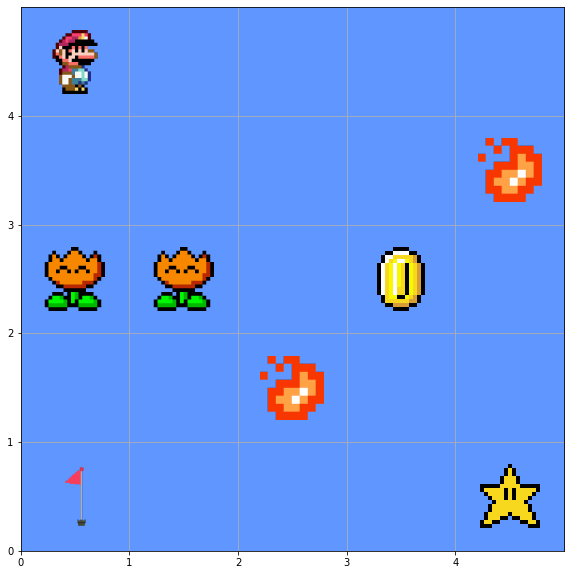

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

State Step 0
Action Taken: D 
Action Performed: D 
Reward: 0.0


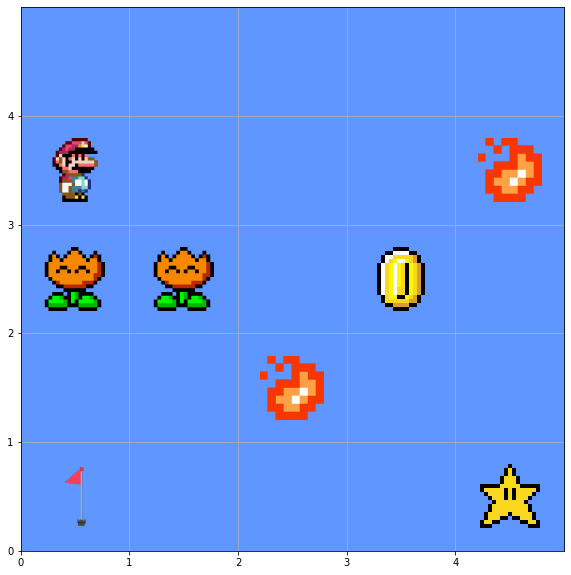

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

State Step 1
Action Taken: U 
Action Performed: U 
Reward: 0.0


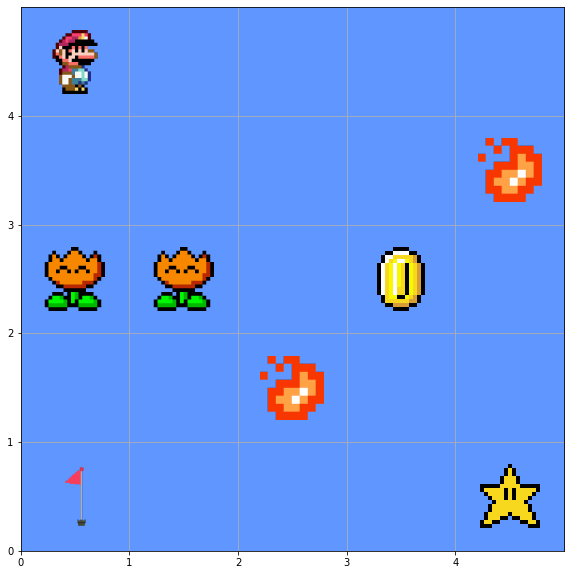

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

State Step 2
Action Taken: R 
Action Performed: R 
Reward: 0.0


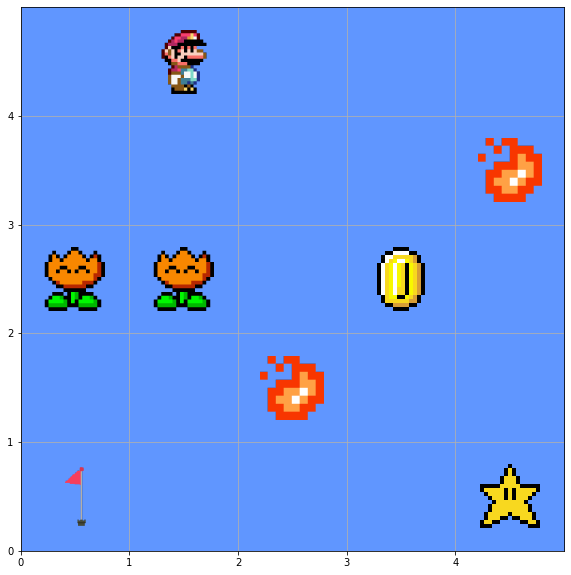

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

State Step 3
Action Taken: L 
Action Performed: L 
Reward: 0.0


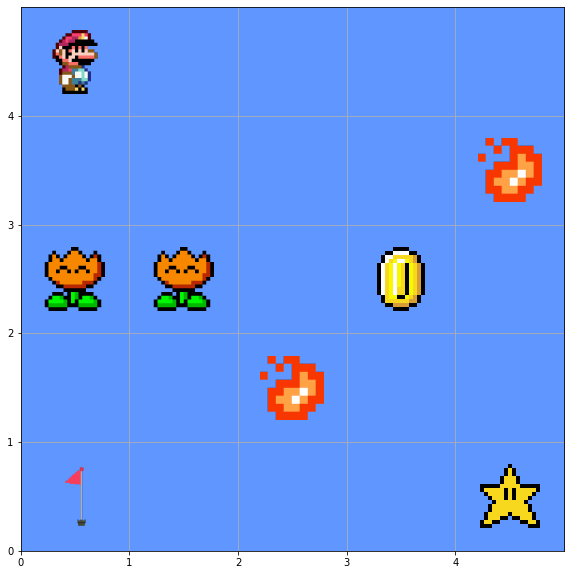

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

State Step 4
Action Taken: R 
Action Performed: R 
Reward: 0.0


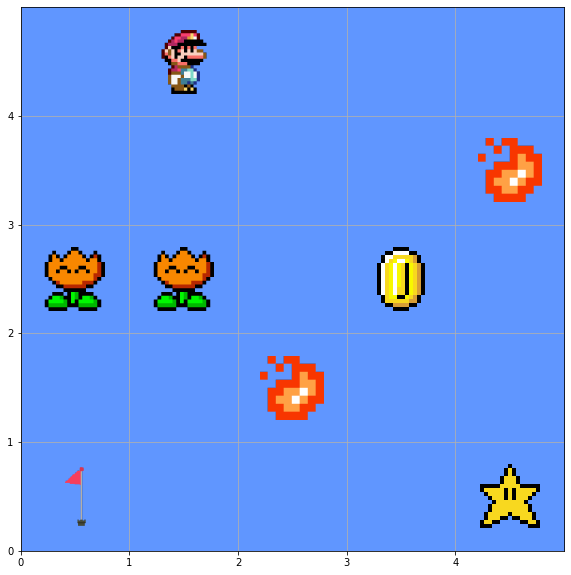

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

State Step 5
Action Taken: U 
Action Performed: U 
Reward: 0.0


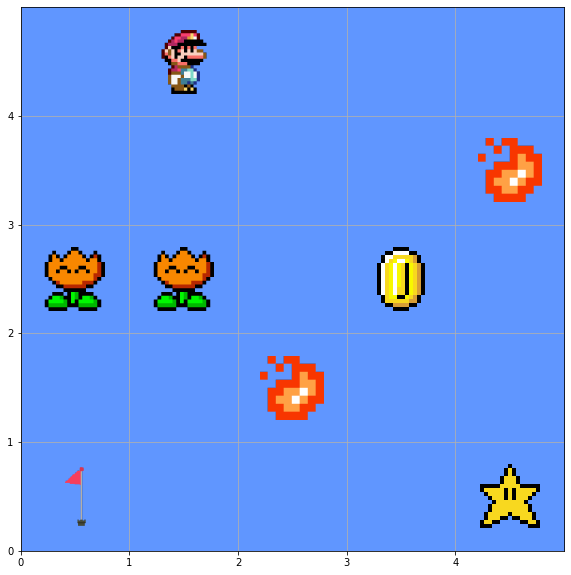

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

State Step 6
Action Taken: D 
Action Performed: D 
Reward: 0.0


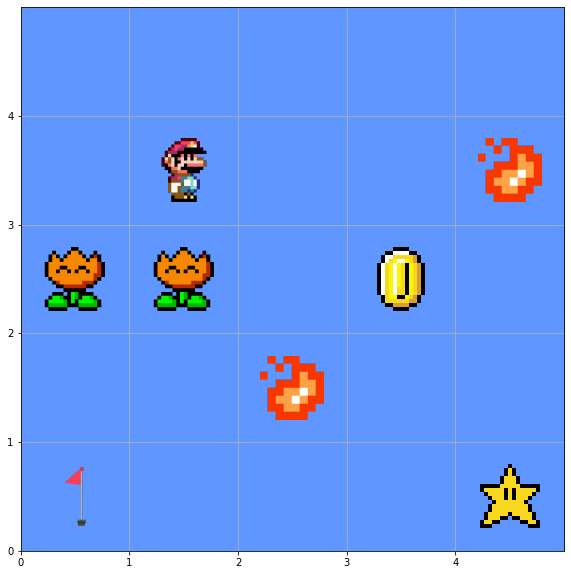

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

State Step 7
Action Taken: R 
Action Performed: R 
Reward: 0.0


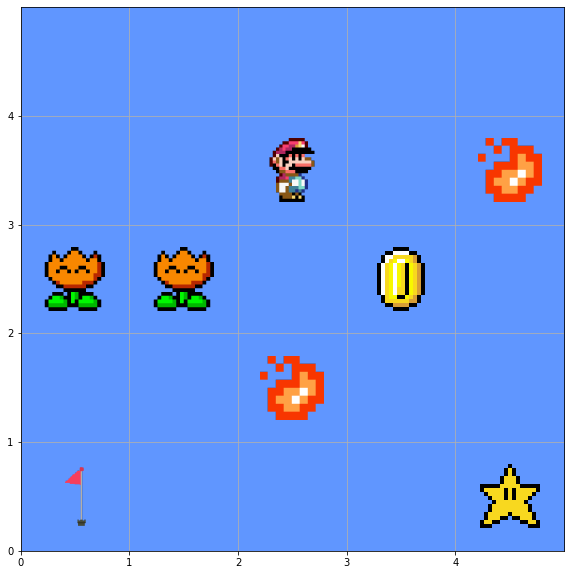

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

State Step 8
Action Taken: U 
Action Performed: U 
Reward: 0.0


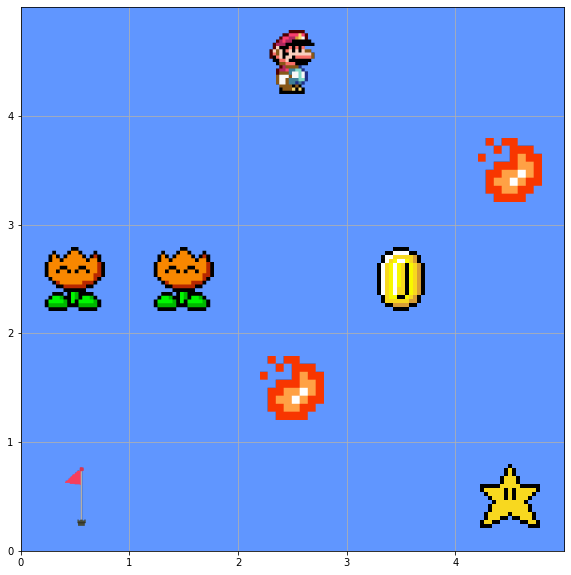

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

State Step 9
Action Taken: U 
Action Performed: U 
Reward: 0.0


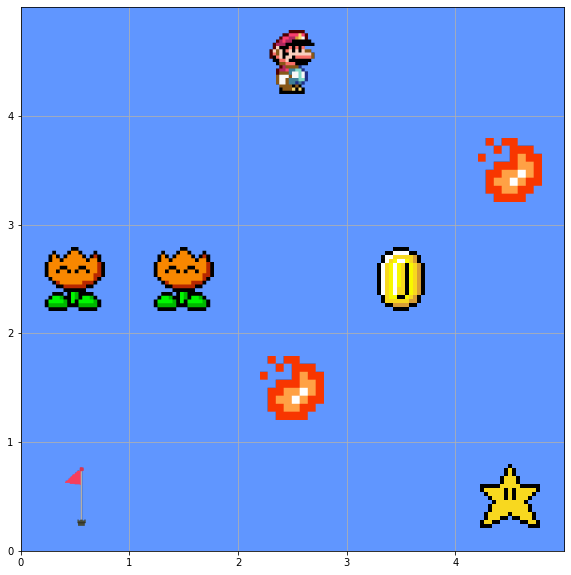

<IPython.core.display.Javascript object>

Cumulative Reward 0.0


In [110]:
env = MyMarioEnvironment(environment=STATES,actions=ACTIONS,rewards=REWARDS,p_transition=1.0,environment_type='deterministic')
mario = RandomMarioAgent(env=env, animate=False)
mario.run(maxsteps=10)

# Stochastic Environment Run

""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Initial State - Step 0


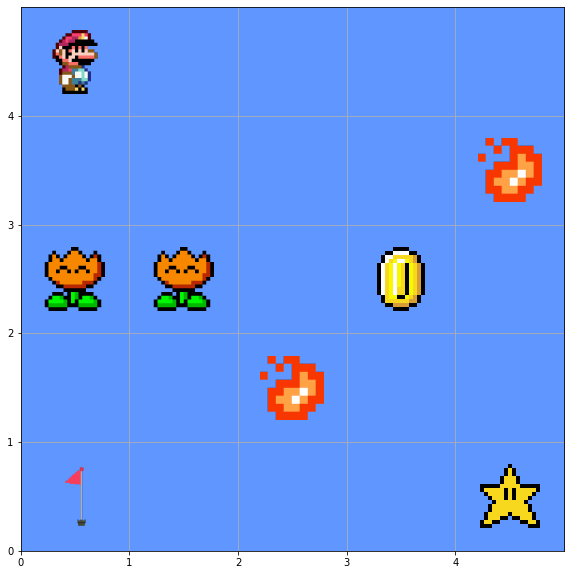

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

State Step 0
Action Taken: L 
Action Performed: L 
Reward: 0.0


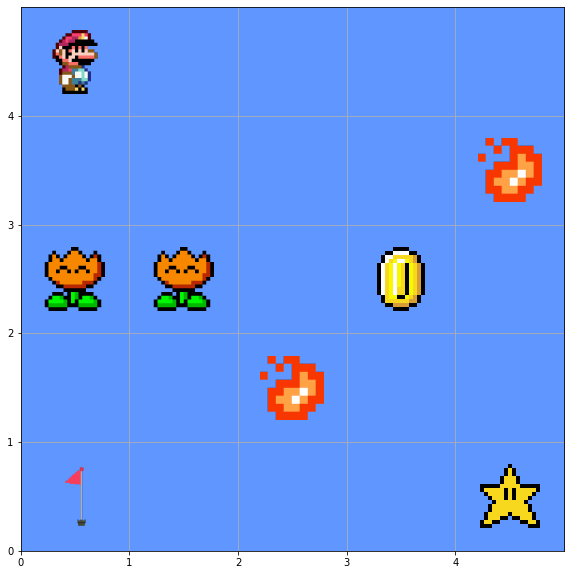

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

State Step 1
Action Taken: U 
Action Performed: U 
Reward: 0.0


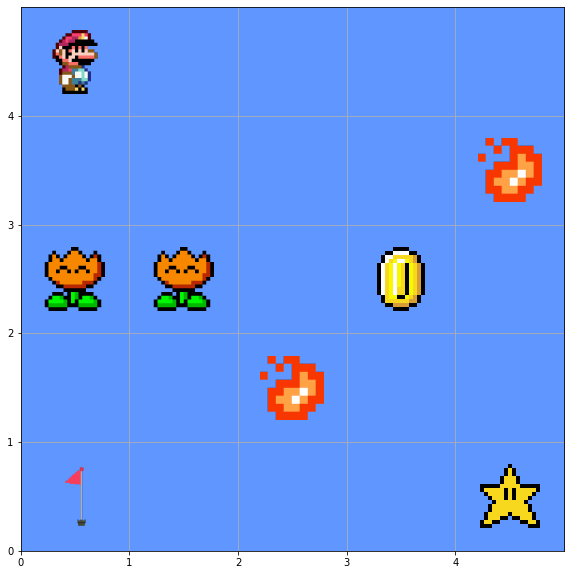

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

State Step 2
Action Taken: L 
Action Performed: L 
Reward: 0.0


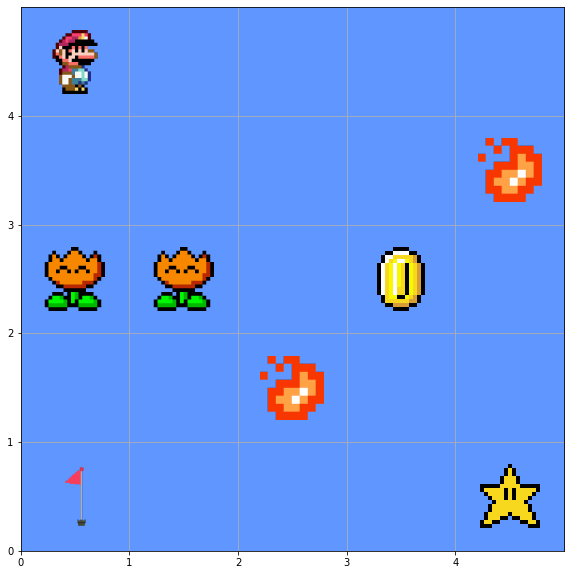

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

State Step 3
Action Taken: D 
Action Performed: R 
Reward: 0.0


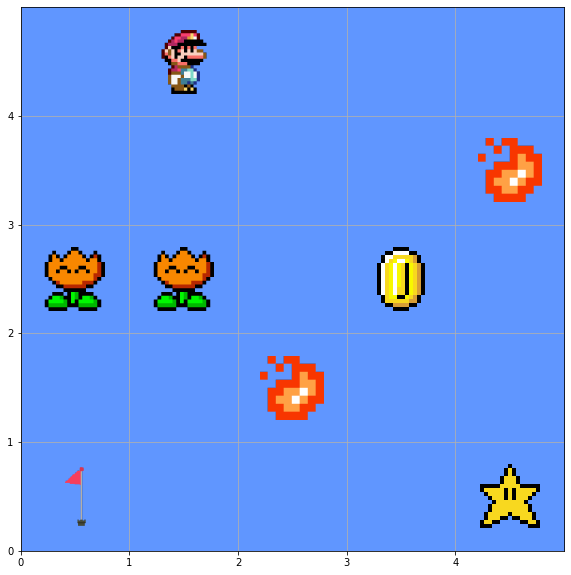

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

State Step 4
Action Taken: L 
Action Performed: L 
Reward: 0.0


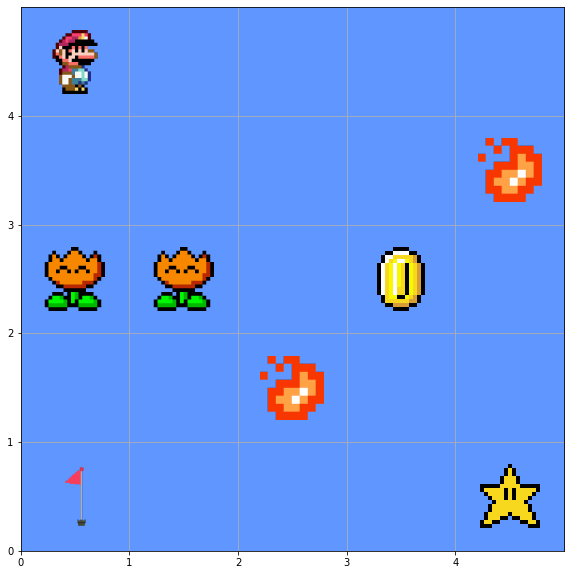

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

State Step 5
Action Taken: L 
Action Performed: U 
Reward: 0.0


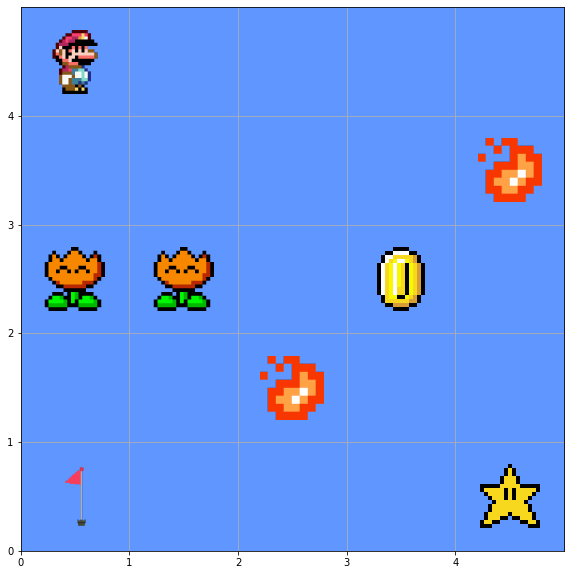

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

State Step 6
Action Taken: L 
Action Performed: L 
Reward: 0.0


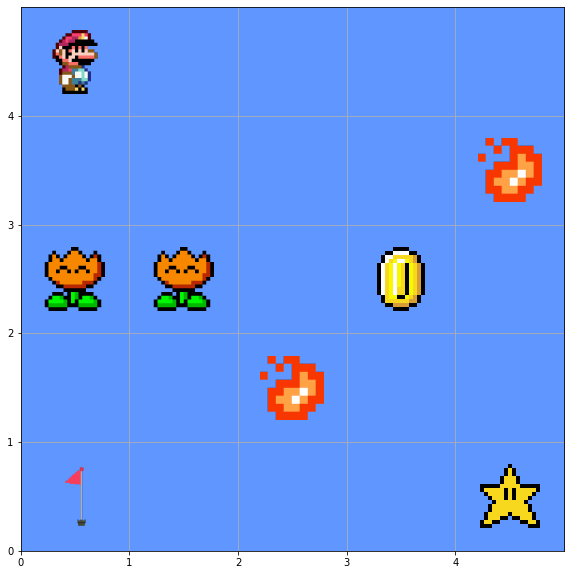

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

State Step 7
Action Taken: L 
Action Performed: L 
Reward: 0.0


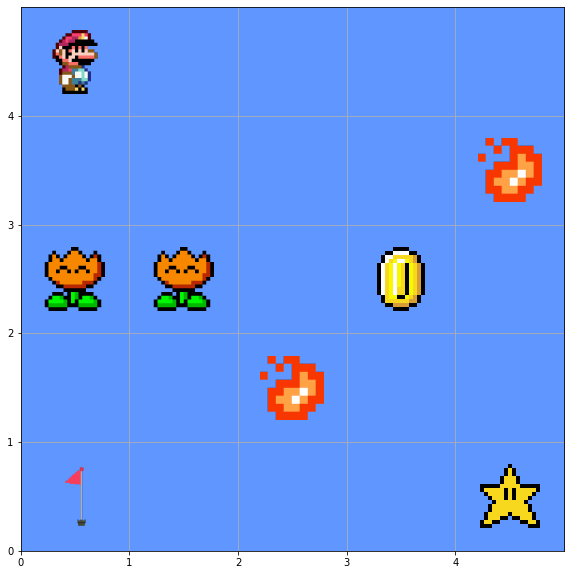

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

State Step 8
Action Taken: U 
Action Performed: U 
Reward: 0.0


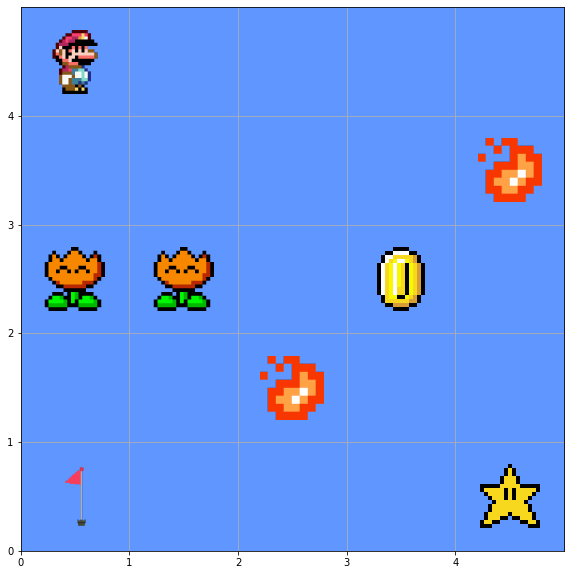

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

State Step 9
Action Taken: R 
Action Performed: R 
Reward: 0.0


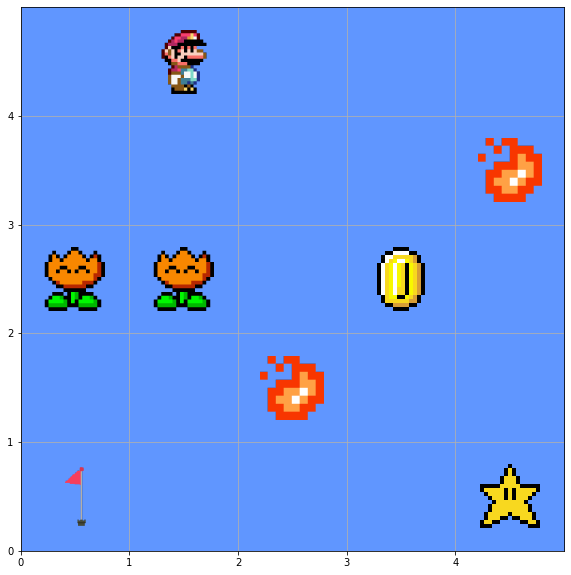

<IPython.core.display.Javascript object>

Cumulative Reward 0.0


In [111]:
env = MyMarioEnvironment(environment=STATES,actions=ACTIONS,rewards=REWARDS,p_transition=0.8,environment_type='stochastic')
mario = RandomMarioAgent(env,animate=False)
mario.run(maxsteps=10)

# Part 2 Solving RL Environment

In [4]:
class MarioAgent:
    def __init__(self, env):
        self.env = env
        self.alpha = 0.1  
        self.gamma = 0.9
        self.epsilon = 1.0
        self.lmda = 0.01
        self.reward_list = []
        self.dc_reward = 0
        self.epsilon_list = []
        self.timesteps = []
    
    def choose_action(self, current_state, test=False):
        random_no = np.random.random()
        if self.epsilon > random_no and not test:
            return np.random.choice(self.env.action_space.n)
        else:
            return np.argmax(self.Q[current_state])
 
    def step(self, state, test=False):
        return self.choose_action(state, test)
    
    def plot(self, test=False):
      if test:
        plt.clf()
        plt.figure(figsize=(15, 10))
        plt.plot(self.reward_list_test, 'r-')
        plt.xlabel('Episode', fontsize=28)
        plt.ylabel('Reward Value', fontsize=28)
        plt.title('Rewards Per Episode (Training)', fontsize=36)
        plt.xticks(fontsize=24)
        plt.yticks(fontsize=24)
        # plt.yticks([-100, -50, 0, 10, 20], fontsize=24)
        plt.ylim(ymin=-102, ymax=102)
        # plt.xlim(xmin=0, xmax=self.max_episodes_test)
        plt.grid()
        plt.show()
      else:
        plt.clf()
        plt.figure(figsize=(15, 10))
        plt.plot(self.epsilon_list, linewidth=4)
        plt.xlabel('Episode', fontsize=28)
        plt.ylabel('Epsilon Values', fontsize=28)
        plt.title('Epsilon Decay', fontsize=36)
        plt.xticks(fontsize=24)
        plt.yticks(fontsize=24)
        plt.ylim(ymin=0, ymax=1)
        plt.xlim(xmin=0, xmax=self.max_episodes)
        plt.grid()
        plt.show()

        plt.clf()
        plt.figure(figsize=(15, 10))
        plt.plot(self.reward_list, 'ro')
        plt.xlabel('Episode', fontsize=28)
        plt.ylabel('Reward Value', fontsize=28)
        plt.title('Rewards Per Episode (Training)', fontsize=36)
        plt.xticks(fontsize=24)
        plt.yticks(fontsize=24)
        # plt.yticks([-100, -50, 0, 10, 20], fontsize=24)
        plt.ylim(ymin=-102, ymax=102)
        plt.xlim(xmin=0, xmax=self.max_episodes)
        plt.grid()
        plt.show()

    
    def run(self, steps=10, animate=True):
      obs = self.env.reset()
      done = False
      current_state = self.env.state
      output_grid = widgets.Grid(1, 1)
      with output_grid.output_to(0, 0):
        print("Initial State - Step 0")
        self.env.render(mode="human",icons=ICONS)
      
      timestep = 0
      cumulative_reward = 0
      while not done and timestep<steps:
        timestep +=1
        action = self.step(current_state, test=True)
        obs, reward, done, info = self.env.step(self.env.actions[action][0])
        new_state = self.env.state
        cumulative_reward += reward
        current_state = new_state

        with output_grid.output_to(0, 0):
          if animate:
            output_grid.clear_cell()
          print(f"State Step {timestep}")
          print(f"Action Taken: {self.env.actions[action][0]} \nAction Performed: {info['action_performed']} \nReward: {cumulative_reward}")
          self.env.render(mode="human",icons=ICONS)
          time.sleep(2)

    def test(self, episodes=20, steps=100):
      self.max_episodes_test = episodes
      self.max_steps_test = steps
      self.timesteps_test = []
      self.reward_list_test = []

      for e in range(self.max_episodes_test):
        obs = self.env.reset()
        done = False
        dc_reward = 0
        timesteps = 0
        current_state = self.env.state
        for step in range(self.max_steps):
          timesteps += 1
          action = self.step(current_state, test=True)
          obs, reward, done, info = self.env.step(self.env.actions[action][0])
          new_state = self.env.state
          dc_reward += reward
          current_state = new_state
          if done:
            break
        print(f"Episode - {e+1} : Done \t Reward: {dc_reward} \t Timesteps: {timesteps}")
        self.timesteps_test.append(timesteps)
        self.reward_list_test.append(dc_reward)

    def train(self, episodes=1000, steps=100, epsilon=1.0, lmda=0.9954, gamma=0.99, alpha=0.1, animate=False):
      #Implemented by Child Class
      pass
      

# SARSA Implementation

In [5]:
class SarsaLearningMarioAgent(MarioAgent):
    def __init__(self, env):
      super(SarsaLearningMarioAgent,self).__init__(env)
      self.Q = None
  
    def initialize_q_table(self, mode):
      valid_modes = ["zeros","random"]
      self.Q = [[0 for a in range(self.env.action_space.n)] for s in range(self.env.observation_space.n)]
      if mode not in valid_modes:
        raise ValueError(f"Error: mode must be one of {valid_modes}")
      for s in range(self.env.observation_space.n):
        for a in range(self.env.action_space.n):
          if mode == "zeros":
            self.Q[s][a] = 0
          elif mode == "random":
            self.Q[s][a] = np.random.uniform(low=-5, high=15)

    def train(self, episodes=1000, steps=100, epsilon=1.0, lmda=0.9954, gamma=0.99, alpha=0.1, animate=False):
      self.max_episodes = episodes
      self.max_steps = steps
      self.epsilon = epsilon
      self.lmda = 0.01**(1/self.max_episodes) if lmda is None else lmda 
      self.gamma = gamma
      self.alpha = alpha

      for e in range(self.max_episodes):
        obs = self.env.reset()
        done = False
        dc_reward = 0
        timesteps = 0
        current_state = self.env.state
        current_action = self.step(current_state)
        for step in range(self.max_steps):
          timesteps += 1
          obs, reward, done, info = self.env.step(self.env.actions[current_action][0])
          new_state = self.env.state
          new_action = self.step(new_state)

          self.Q[current_state][current_action] = self.Q[current_state][current_action] + self.alpha*(reward + self.gamma*self.Q[new_state][new_action] - self.Q[current_state][current_action])
          
          dc_reward += reward
          current_state = new_state
          current_action = new_action
          if done:
            break
        print(f"Episode - {e+1} : Done \t Reward: {dc_reward} \t Timesteps: {timesteps}")
        self.timesteps.append(timesteps)
        self.reward_list.append(dc_reward)
        self.epsilon_list.append(self.epsilon)
        self.epsilon = max(0.01, self.epsilon*self.lmda)


## Solving Deterministic Environment - SARSA 

In [114]:
envD = MyMarioEnvironment(environment=STATES,actions=ACTIONS,rewards=REWARDS,p_transition=1.0,environment_type='deterministic')
marioSD = SarsaLearningMarioAgent(envD)
marioSD.initialize_q_table("zeros")

Episode - 1 : Done 	 Reward: -12.0 	 Timesteps: 21
Episode - 2 : Done 	 Reward: -16.0 	 Timesteps: 34
Episode - 3 : Done 	 Reward: 7.0 	 Timesteps: 19
Episode - 4 : Done 	 Reward: -22.0 	 Timesteps: 88
Episode - 5 : Done 	 Reward: -2.0 	 Timesteps: 86
Episode - 6 : Done 	 Reward: -48.0 	 Timesteps: 100
Episode - 7 : Done 	 Reward: -60.0 	 Timesteps: 100
Episode - 8 : Done 	 Reward: -9.0 	 Timesteps: 100
Episode - 9 : Done 	 Reward: -5.0 	 Timesteps: 11
Episode - 10 : Done 	 Reward: 7.0 	 Timesteps: 10
Episode - 11 : Done 	 Reward: 7.0 	 Timesteps: 36
Episode - 12 : Done 	 Reward: -20.0 	 Timesteps: 100
Episode - 13 : Done 	 Reward: 4.0 	 Timesteps: 12
Episode - 14 : Done 	 Reward: -34.0 	 Timesteps: 100
Episode - 15 : Done 	 Reward: -4.0 	 Timesteps: 54
Episode - 16 : Done 	 Reward: 4.0 	 Timesteps: 70
Episode - 17 : Done 	 Reward: 7.0 	 Timesteps: 10
Episode - 18 : Done 	 Reward: -29.0 	 Timesteps: 100
Episode - 19 : Done 	 Reward: 0.0 	 Timesteps: 22
Episode - 20 : Done 	 Reward: -28

<Figure size 432x288 with 0 Axes>

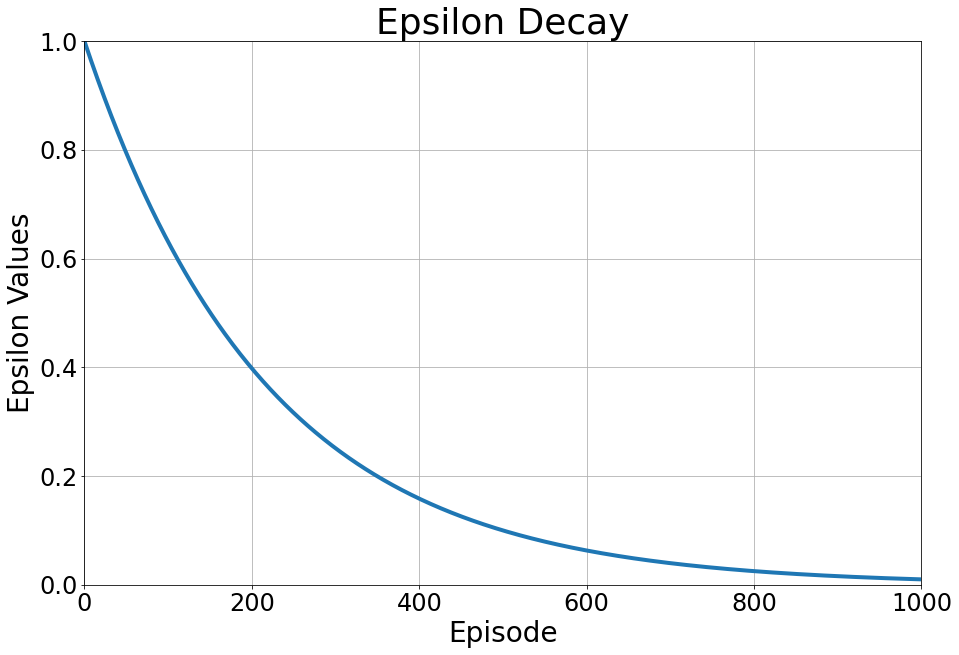

<Figure size 432x288 with 0 Axes>

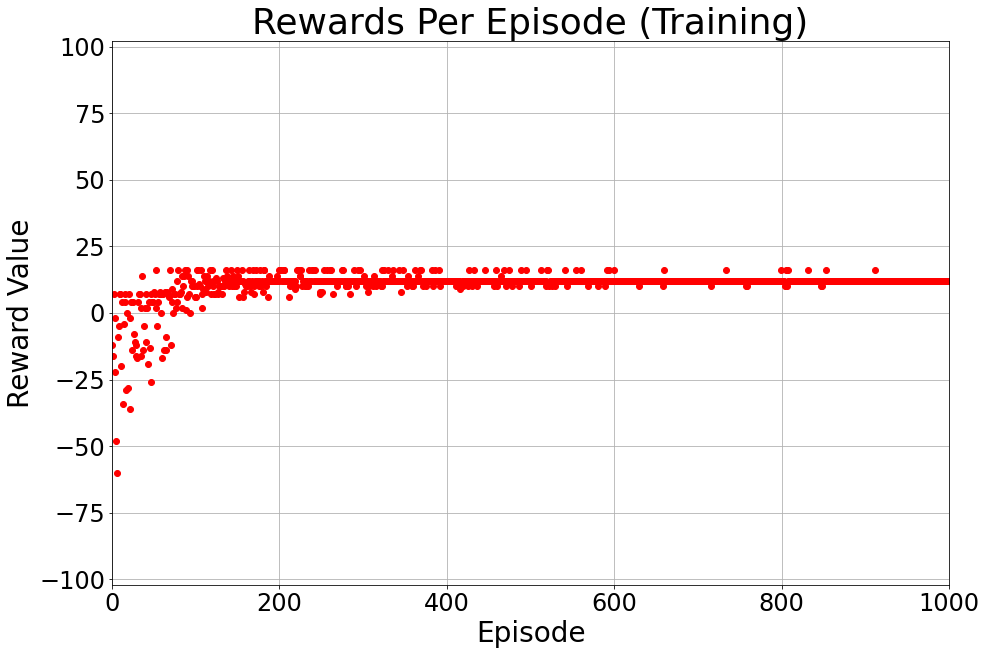

In [115]:
marioSD.train(episodes=1000, lmda=None, epsilon=1.0)
marioSD.plot()

Episode - 1 : Done 	 Reward: 12.0 	 Timesteps: 10
Episode - 2 : Done 	 Reward: 12.0 	 Timesteps: 10
Episode - 3 : Done 	 Reward: 12.0 	 Timesteps: 10
Episode - 4 : Done 	 Reward: 12.0 	 Timesteps: 10
Episode - 5 : Done 	 Reward: 12.0 	 Timesteps: 10
Episode - 6 : Done 	 Reward: 12.0 	 Timesteps: 10
Episode - 7 : Done 	 Reward: 12.0 	 Timesteps: 10
Episode - 8 : Done 	 Reward: 12.0 	 Timesteps: 10
Episode - 9 : Done 	 Reward: 12.0 	 Timesteps: 10
Episode - 10 : Done 	 Reward: 12.0 	 Timesteps: 10
Episode - 11 : Done 	 Reward: 12.0 	 Timesteps: 10
Episode - 12 : Done 	 Reward: 12.0 	 Timesteps: 10
Episode - 13 : Done 	 Reward: 12.0 	 Timesteps: 10
Episode - 14 : Done 	 Reward: 12.0 	 Timesteps: 10
Episode - 15 : Done 	 Reward: 12.0 	 Timesteps: 10
Episode - 16 : Done 	 Reward: 12.0 	 Timesteps: 10
Episode - 17 : Done 	 Reward: 12.0 	 Timesteps: 10
Episode - 18 : Done 	 Reward: 12.0 	 Timesteps: 10
Episode - 19 : Done 	 Reward: 12.0 	 Timesteps: 10
Episode - 20 : Done 	 Reward: 12.0 	 Tim

<Figure size 432x288 with 0 Axes>

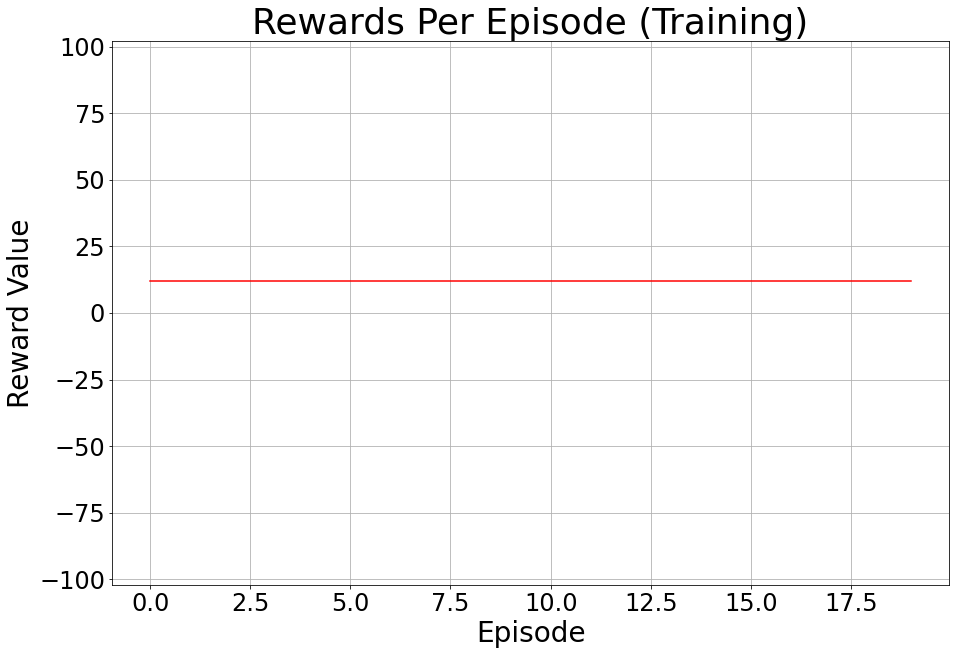

In [116]:
marioSD.test(episodes=20)
marioSD.plot(test=True)

## Solving Stochastic Environment - SARSA 

In [117]:
envS = MyMarioEnvironment(environment=STATES,actions=ACTIONS,rewards=REWARDS,p_transition=0.9,environment_type='stochastic')
marioSS = SarsaLearningMarioAgent(envS)
marioSS.initialize_q_table("zeros")

Episode - 1 : Done 	 Reward: 1.0 	 Timesteps: 13
Episode - 2 : Done 	 Reward: 7.0 	 Timesteps: 8
Episode - 3 : Done 	 Reward: -29.0 	 Timesteps: 100
Episode - 4 : Done 	 Reward: -9.0 	 Timesteps: 47
Episode - 5 : Done 	 Reward: -25.0 	 Timesteps: 100
Episode - 6 : Done 	 Reward: 4.0 	 Timesteps: 77
Episode - 7 : Done 	 Reward: -26.0 	 Timesteps: 100
Episode - 8 : Done 	 Reward: -22.0 	 Timesteps: 88
Episode - 9 : Done 	 Reward: -15.0 	 Timesteps: 47
Episode - 10 : Done 	 Reward: -15.0 	 Timesteps: 75
Episode - 11 : Done 	 Reward: -26.0 	 Timesteps: 100
Episode - 12 : Done 	 Reward: -17.0 	 Timesteps: 84
Episode - 13 : Done 	 Reward: -42.0 	 Timesteps: 100
Episode - 14 : Done 	 Reward: -23.0 	 Timesteps: 47
Episode - 15 : Done 	 Reward: -39.0 	 Timesteps: 69
Episode - 16 : Done 	 Reward: -5.0 	 Timesteps: 100
Episode - 17 : Done 	 Reward: -5.0 	 Timesteps: 68
Episode - 18 : Done 	 Reward: -8.0 	 Timesteps: 43
Episode - 19 : Done 	 Reward: -19.0 	 Timesteps: 41
Episode - 20 : Done 	 Rewa

<Figure size 432x288 with 0 Axes>

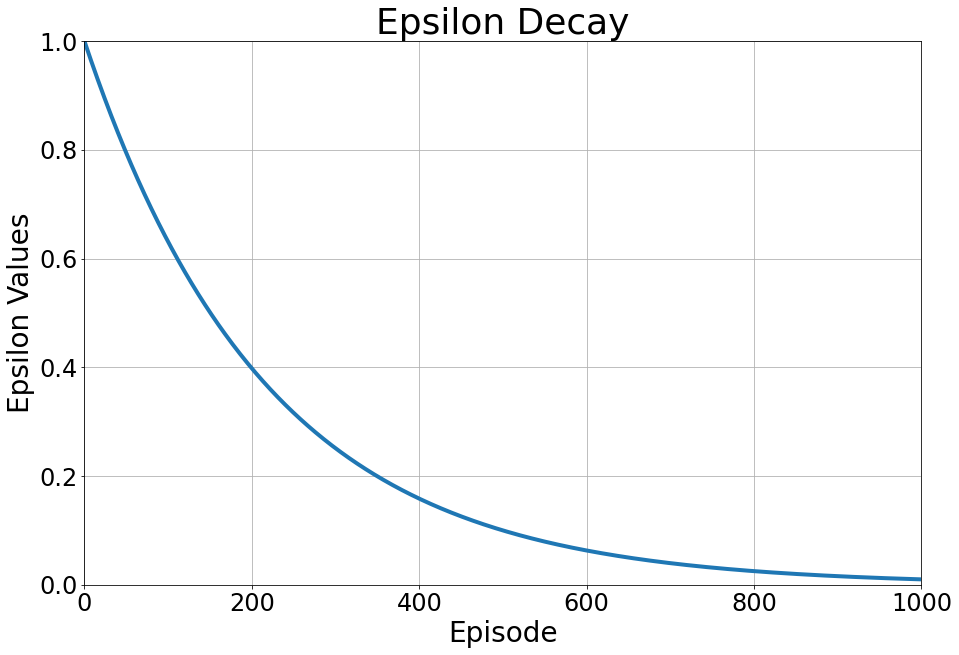

<Figure size 432x288 with 0 Axes>

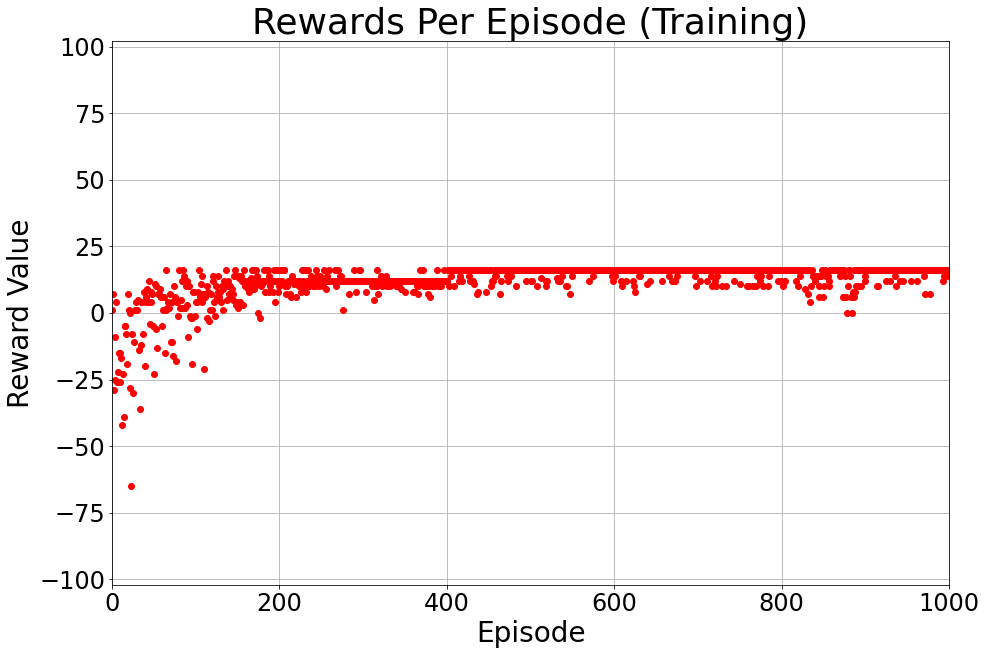

In [118]:
marioSS.train(episodes=1000, lmda=None, epsilon=1.0)
marioSS.plot()

Episode - 1 : Done 	 Reward: 12.0 	 Timesteps: 13
Episode - 2 : Done 	 Reward: 10.0 	 Timesteps: 12
Episode - 3 : Done 	 Reward: 16.0 	 Timesteps: 15
Episode - 4 : Done 	 Reward: 16.0 	 Timesteps: 13
Episode - 5 : Done 	 Reward: 16.0 	 Timesteps: 17
Episode - 6 : Done 	 Reward: 16.0 	 Timesteps: 15
Episode - 7 : Done 	 Reward: 16.0 	 Timesteps: 15
Episode - 8 : Done 	 Reward: 16.0 	 Timesteps: 13
Episode - 9 : Done 	 Reward: 16.0 	 Timesteps: 12
Episode - 10 : Done 	 Reward: 16.0 	 Timesteps: 12
Episode - 11 : Done 	 Reward: 16.0 	 Timesteps: 19
Episode - 12 : Done 	 Reward: 16.0 	 Timesteps: 14
Episode - 13 : Done 	 Reward: 16.0 	 Timesteps: 12
Episode - 14 : Done 	 Reward: 16.0 	 Timesteps: 12
Episode - 15 : Done 	 Reward: 16.0 	 Timesteps: 12
Episode - 16 : Done 	 Reward: 16.0 	 Timesteps: 12
Episode - 17 : Done 	 Reward: 16.0 	 Timesteps: 14
Episode - 18 : Done 	 Reward: 16.0 	 Timesteps: 14
Episode - 19 : Done 	 Reward: 16.0 	 Timesteps: 17
Episode - 20 : Done 	 Reward: 16.0 	 Tim

<Figure size 432x288 with 0 Axes>

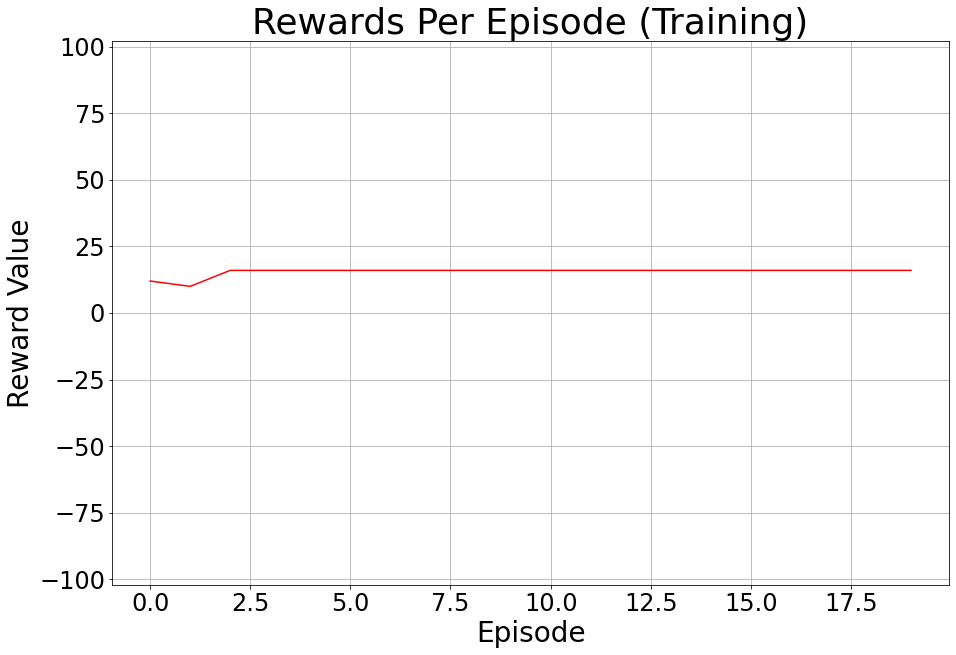

In [131]:
marioSS.test(episodes=20)
marioSS.plot(test=True)

# Q-Learning Implementation

In [7]:
class QLearningMarioAgent(MarioAgent):
  def __init__(self, env, q_table_mode="zeros"):
    super(QLearningMarioAgent,self).__init__(env)
    self.Q = None
  
  def initialize_q_table(self, mode):
    valid_modes = ["zeros","random"]
    self.Q = [[0 for a in range(self.env.action_space.n)] for s in range(self.env.observation_space.n)]
    if mode not in valid_modes:
      raise ValueError(f"Error: mode must be one of {valid_modes}")
    for s in range(self.env.observation_space.n):
      for a in range(self.env.action_space.n):
        if mode == "zeros":
          self.Q[s][a] = 0
        elif mode == "random":
          self.Q[s][a] = np.random.uniform(low=-5, high=15)

  def train(self, episodes=1000, steps=100, epsilon=1.0, lmda=0.9954, gamma=0.99, alpha=0.1, animate=False):
    self.max_episodes = episodes
    self.max_steps = steps
    self.epsilon = epsilon
    self.lmda = 0.01**(1/self.max_episodes) if lmda is None else lmda 
    self.gamma = gamma
    self.alpha = alpha
    
    for e in range(self.max_episodes):
      obs = self.env.reset()
      done = False
      current_state = self.env.state
      dc_reward = 0
      timesteps = 0
      for step in range(self.max_steps):
        timesteps += 1
        action = self.step(current_state)
        obs, reward, done, info = self.env.step(self.env.actions[action][0])
        new_state = self.env.state
        dc_reward += reward
        self.Q[current_state][action] = self.Q[current_state][action] + self.alpha*(reward + self.gamma*max(self.Q[new_state]) - self.Q[current_state][action])
        current_state = new_state
        if done:
          break
      print(f"Episode - {e+1} : Done \t Reward: {dc_reward} \t Timesteps: {timesteps}")
      self.timesteps.append(timesteps)
      self.reward_list.append(dc_reward)
      self.epsilon_list.append(self.epsilon)
      self.epsilon = max(0.01, self.epsilon*self.lmda)


## Solving Deterministic Environment - Q-Learning

In [121]:
envD = MyMarioEnvironment(environment=STATES,actions=ACTIONS,rewards=REWARDS,p_transition=1.0,environment_type='deterministic')
marioQD = QLearningMarioAgent(envD)
marioQD.initialize_q_table("zeros")

### Training

Episode - 1 : Done 	 Reward: -34.0 	 Timesteps: 100
Episode - 2 : Done 	 Reward: -23.0 	 Timesteps: 100
Episode - 3 : Done 	 Reward: 7.0 	 Timesteps: 6
Episode - 4 : Done 	 Reward: -25.0 	 Timesteps: 100
Episode - 5 : Done 	 Reward: -18.0 	 Timesteps: 57
Episode - 6 : Done 	 Reward: -25.0 	 Timesteps: 87
Episode - 7 : Done 	 Reward: -26.0 	 Timesteps: 100
Episode - 8 : Done 	 Reward: 1.0 	 Timesteps: 21
Episode - 9 : Done 	 Reward: 4.0 	 Timesteps: 25
Episode - 10 : Done 	 Reward: -11.0 	 Timesteps: 39
Episode - 11 : Done 	 Reward: -23.0 	 Timesteps: 88
Episode - 12 : Done 	 Reward: 7.0 	 Timesteps: 5
Episode - 13 : Done 	 Reward: 3.0 	 Timesteps: 62
Episode - 14 : Done 	 Reward: -28.0 	 Timesteps: 100
Episode - 15 : Done 	 Reward: 7.0 	 Timesteps: 6
Episode - 16 : Done 	 Reward: -39.0 	 Timesteps: 100
Episode - 17 : Done 	 Reward: -21.0 	 Timesteps: 74
Episode - 18 : Done 	 Reward: -2.0 	 Timesteps: 11
Episode - 19 : Done 	 Reward: 0.0 	 Timesteps: 72
Episode - 20 : Done 	 Reward: 4.0

<Figure size 432x288 with 0 Axes>

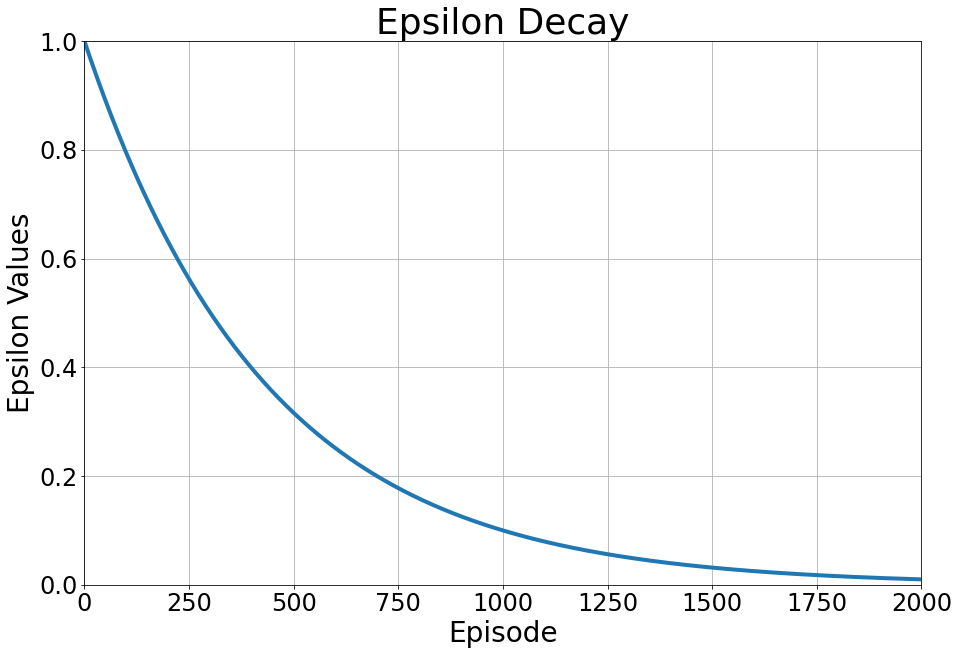

<Figure size 432x288 with 0 Axes>

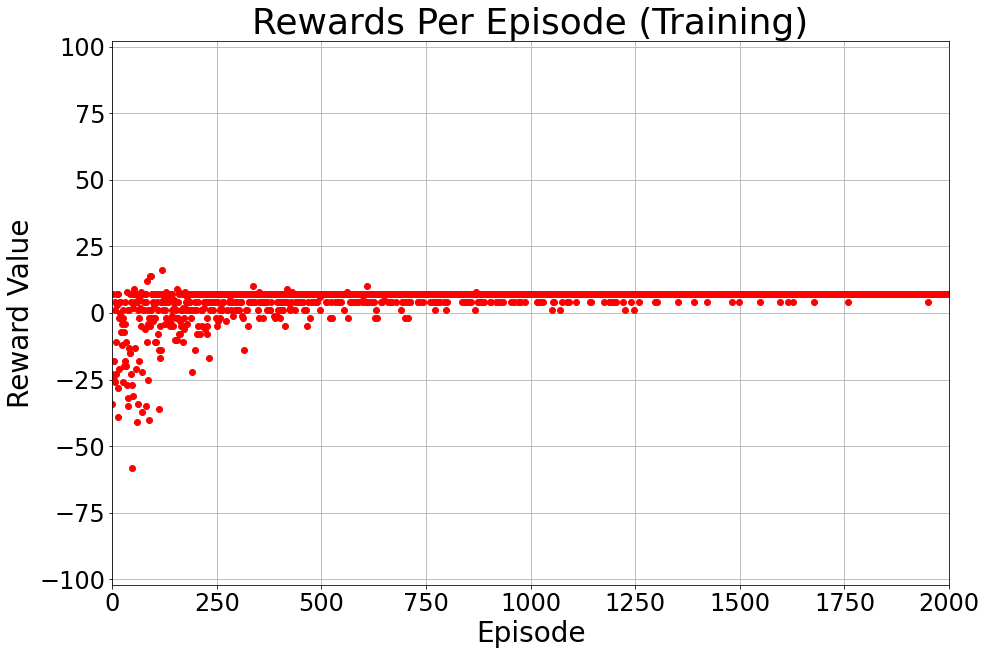

In [122]:

marioQD.train(episodes=2000, lmda=None, epsilon=1.0)
marioQD.plot()

### Evaluation

Episode - 1 : Done 	 Reward: 7.0 	 Timesteps: 4
Episode - 2 : Done 	 Reward: 7.0 	 Timesteps: 4
Episode - 3 : Done 	 Reward: 7.0 	 Timesteps: 4
Episode - 4 : Done 	 Reward: 7.0 	 Timesteps: 4
Episode - 5 : Done 	 Reward: 7.0 	 Timesteps: 4
Episode - 6 : Done 	 Reward: 7.0 	 Timesteps: 4
Episode - 7 : Done 	 Reward: 7.0 	 Timesteps: 4
Episode - 8 : Done 	 Reward: 7.0 	 Timesteps: 4
Episode - 9 : Done 	 Reward: 7.0 	 Timesteps: 4
Episode - 10 : Done 	 Reward: 7.0 	 Timesteps: 4
Episode - 11 : Done 	 Reward: 7.0 	 Timesteps: 4
Episode - 12 : Done 	 Reward: 7.0 	 Timesteps: 4
Episode - 13 : Done 	 Reward: 7.0 	 Timesteps: 4
Episode - 14 : Done 	 Reward: 7.0 	 Timesteps: 4
Episode - 15 : Done 	 Reward: 7.0 	 Timesteps: 4
Episode - 16 : Done 	 Reward: 7.0 	 Timesteps: 4
Episode - 17 : Done 	 Reward: 7.0 	 Timesteps: 4
Episode - 18 : Done 	 Reward: 7.0 	 Timesteps: 4
Episode - 19 : Done 	 Reward: 7.0 	 Timesteps: 4
Episode - 20 : Done 	 Reward: 7.0 	 Timesteps: 4


<Figure size 432x288 with 0 Axes>

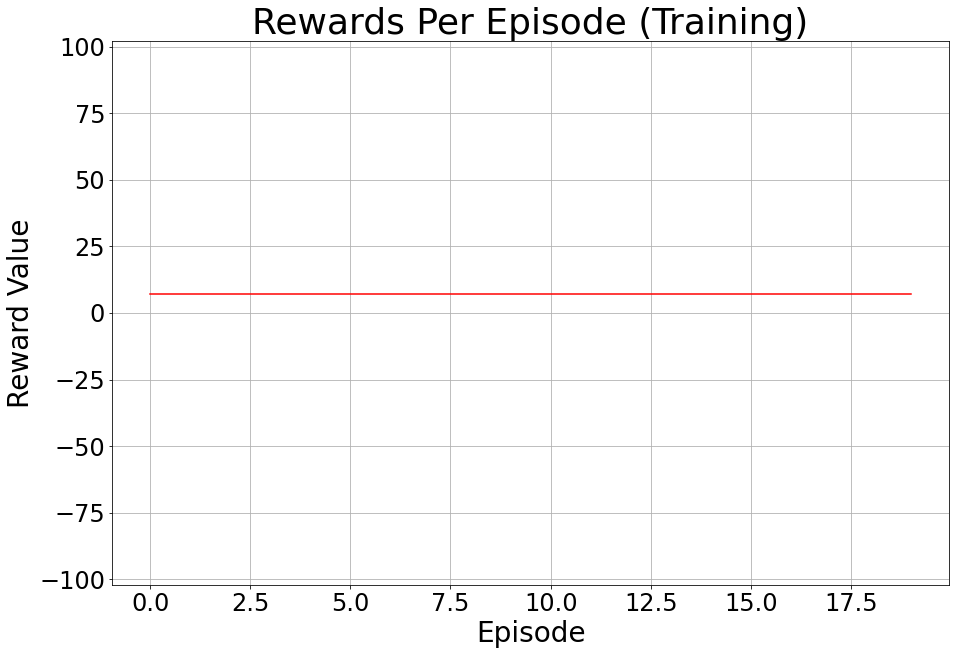

In [123]:
marioQD.test(episodes=20)
marioQD.plot(test=True)

## Solving Stochastic Environment - Q-Learning

In [124]:
envS = MyMarioEnvironment(environment=STATES,actions=ACTIONS,rewards=REWARDS,p_transition=0.9,environment_type='stochastic')
marioQS = QLearningMarioAgent(envS)
marioQS.initialize_q_table(mode="zeros")

### Training

Episode - 1 : Done 	 Reward: 5.0 	 Timesteps: 15
Episode - 2 : Done 	 Reward: 7.0 	 Timesteps: 17
Episode - 3 : Done 	 Reward: -37.0 	 Timesteps: 100
Episode - 4 : Done 	 Reward: -25.0 	 Timesteps: 88
Episode - 5 : Done 	 Reward: -25.0 	 Timesteps: 100
Episode - 6 : Done 	 Reward: 1.0 	 Timesteps: 17
Episode - 7 : Done 	 Reward: -41.0 	 Timesteps: 100
Episode - 8 : Done 	 Reward: 8.0 	 Timesteps: 35
Episode - 9 : Done 	 Reward: -27.0 	 Timesteps: 100
Episode - 10 : Done 	 Reward: 7.0 	 Timesteps: 5
Episode - 11 : Done 	 Reward: 12.0 	 Timesteps: 35
Episode - 12 : Done 	 Reward: 1.0 	 Timesteps: 14
Episode - 13 : Done 	 Reward: -34.0 	 Timesteps: 47
Episode - 14 : Done 	 Reward: -2.0 	 Timesteps: 90
Episode - 15 : Done 	 Reward: -38.0 	 Timesteps: 100
Episode - 16 : Done 	 Reward: -17.0 	 Timesteps: 88
Episode - 17 : Done 	 Reward: -5.0 	 Timesteps: 35
Episode - 18 : Done 	 Reward: -4.0 	 Timesteps: 90
Episode - 19 : Done 	 Reward: -10.0 	 Timesteps: 100
Episode - 20 : Done 	 Reward: -5

<Figure size 432x288 with 0 Axes>

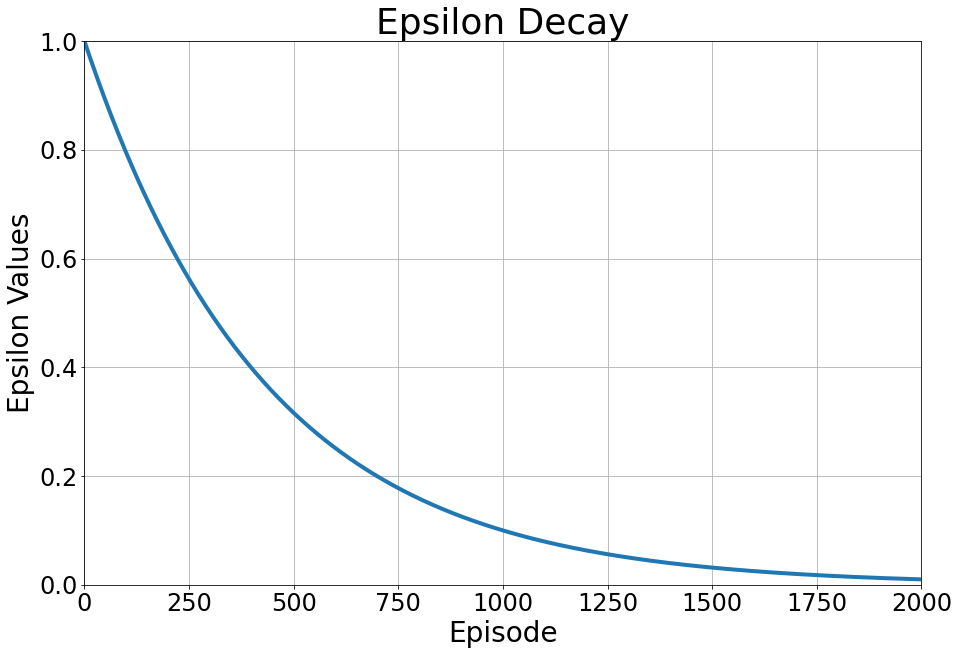

<Figure size 432x288 with 0 Axes>

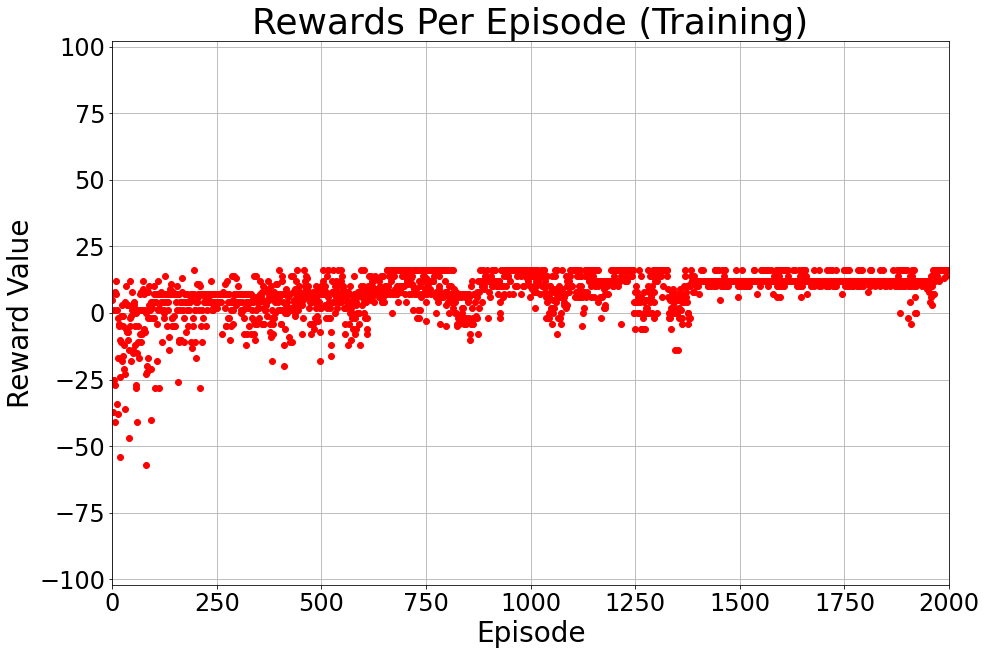

In [125]:
marioQS.train(episodes=2000, lmda=None, epsilon=1.0)
marioQS.plot()

### Evaluation

Episode - 1 : Done 	 Reward: 16.0 	 Timesteps: 12
Episode - 2 : Done 	 Reward: 16.0 	 Timesteps: 14
Episode - 3 : Done 	 Reward: 16.0 	 Timesteps: 13
Episode - 4 : Done 	 Reward: 16.0 	 Timesteps: 15
Episode - 5 : Done 	 Reward: 16.0 	 Timesteps: 13
Episode - 6 : Done 	 Reward: 16.0 	 Timesteps: 16
Episode - 7 : Done 	 Reward: 16.0 	 Timesteps: 14
Episode - 8 : Done 	 Reward: 16.0 	 Timesteps: 14
Episode - 9 : Done 	 Reward: 16.0 	 Timesteps: 12
Episode - 10 : Done 	 Reward: 16.0 	 Timesteps: 12
Episode - 11 : Done 	 Reward: 16.0 	 Timesteps: 14
Episode - 12 : Done 	 Reward: 16.0 	 Timesteps: 12
Episode - 13 : Done 	 Reward: 16.0 	 Timesteps: 12
Episode - 14 : Done 	 Reward: 16.0 	 Timesteps: 12
Episode - 15 : Done 	 Reward: 14.0 	 Timesteps: 16
Episode - 16 : Done 	 Reward: 16.0 	 Timesteps: 12
Episode - 17 : Done 	 Reward: 16.0 	 Timesteps: 18
Episode - 18 : Done 	 Reward: 12.0 	 Timesteps: 10
Episode - 19 : Done 	 Reward: 16.0 	 Timesteps: 14
Episode - 20 : Done 	 Reward: 16.0 	 Tim

<Figure size 432x288 with 0 Axes>

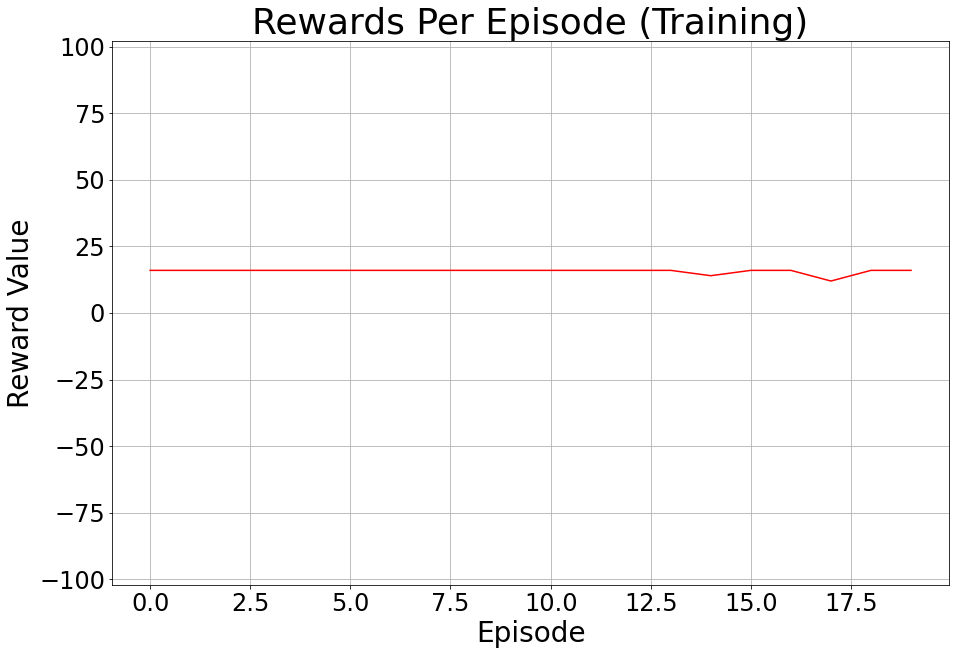

In [126]:
marioQS.test(episodes=20)
marioQS.plot(test=True)

<Figure size 432x288 with 0 Axes>

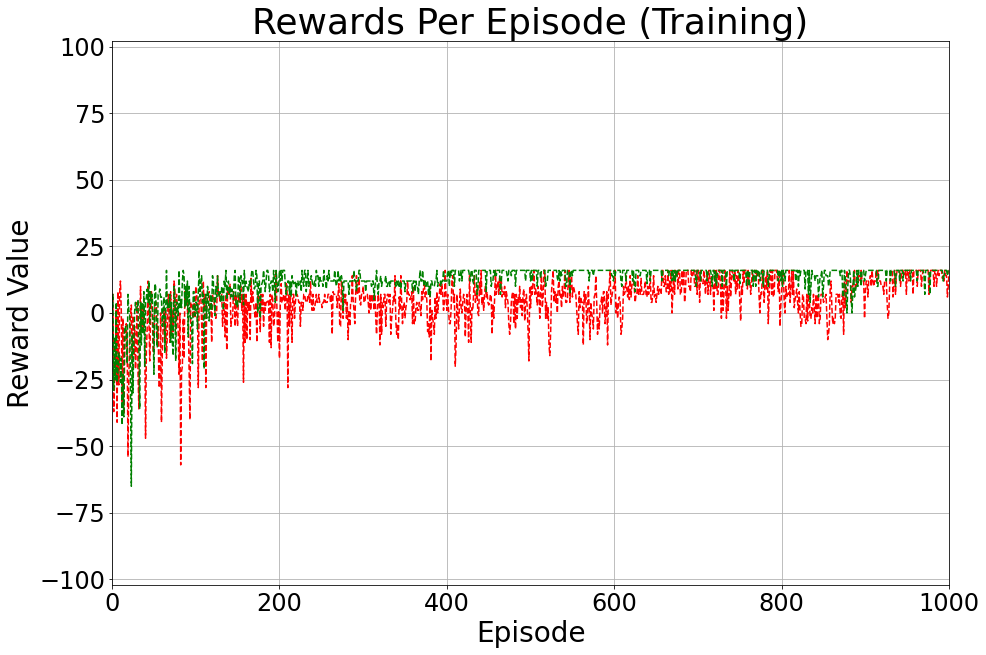

<Figure size 432x288 with 0 Axes>

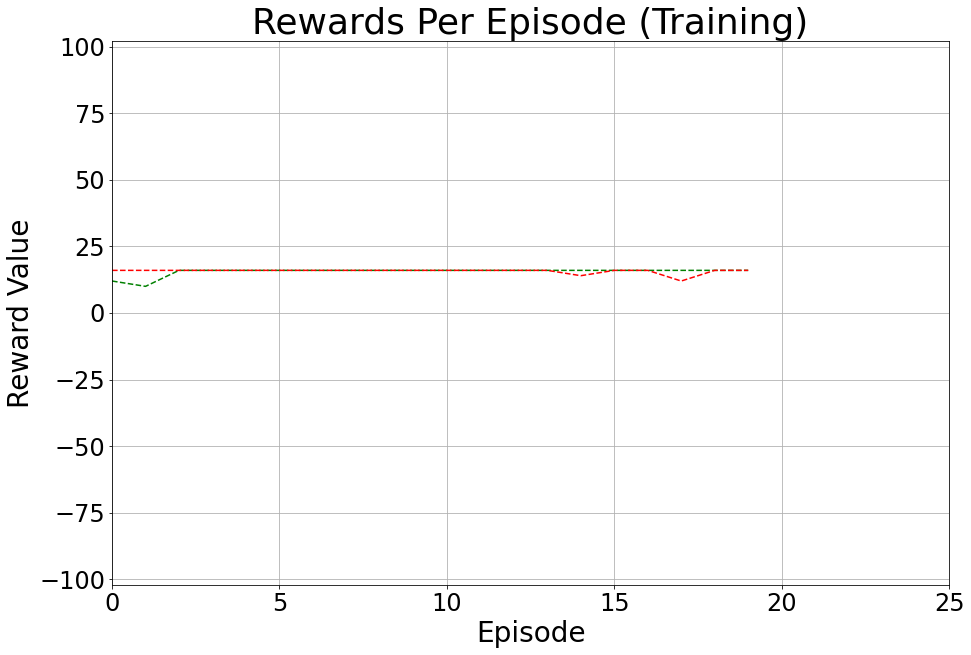

In [135]:
plt.clf()
plt.figure(figsize=(15, 10))
plt.plot(marioQS.reward_list, 'r--')
plt.plot(marioSS.reward_list, 'g--')
plt.xlabel('Episode', fontsize=28)
plt.ylabel('Reward Value', fontsize=28)
plt.title('Rewards Per Episode (Training)', fontsize=36)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
# plt.yticks([-100, -50, 0, 10, 20], fontsize=24)
plt.ylim(ymin=-102, ymax=102)
plt.xlim(xmin=0, xmax=1000)
plt.grid()
plt.show()

plt.clf()
plt.figure(figsize=(15, 10))
plt.plot(marioSS.reward_list_test, 'g--')
plt.plot(marioQS.reward_list_test, 'r--')
plt.xlabel('Episode', fontsize=28)
plt.ylabel('Reward Value', fontsize=28)
plt.title('Rewards Per Episode (Training)', fontsize=36)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
# plt.yticks([-100, -50, 0, 10, 20], fontsize=24)
plt.ylim(ymin=-102, ymax=102)
plt.xlim(xmin=0, xmax=25)
plt.grid()
plt.show()

<Figure size 432x288 with 0 Axes>

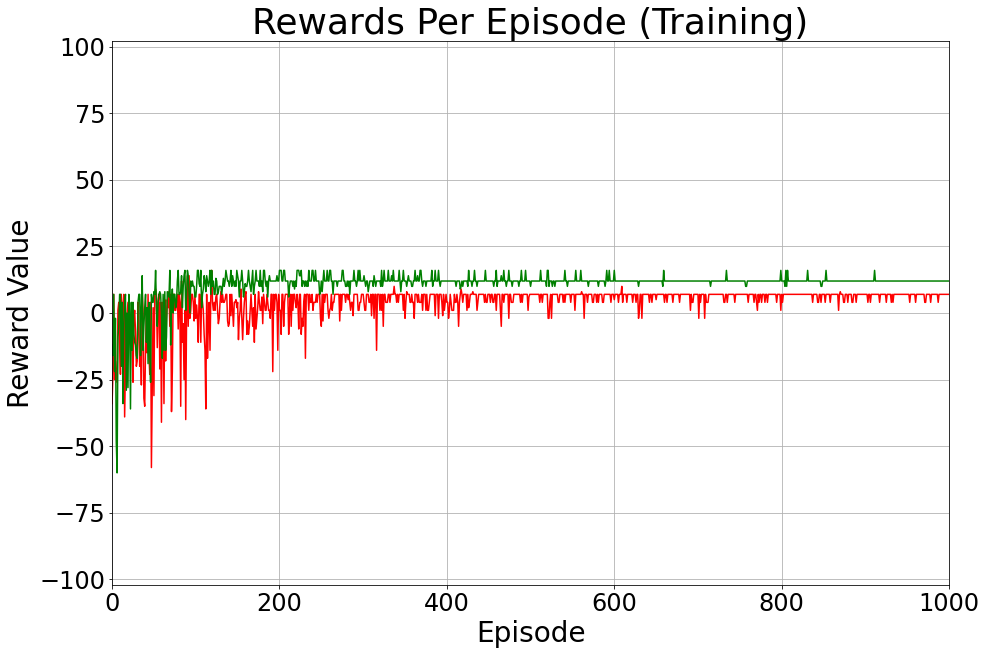

<Figure size 432x288 with 0 Axes>

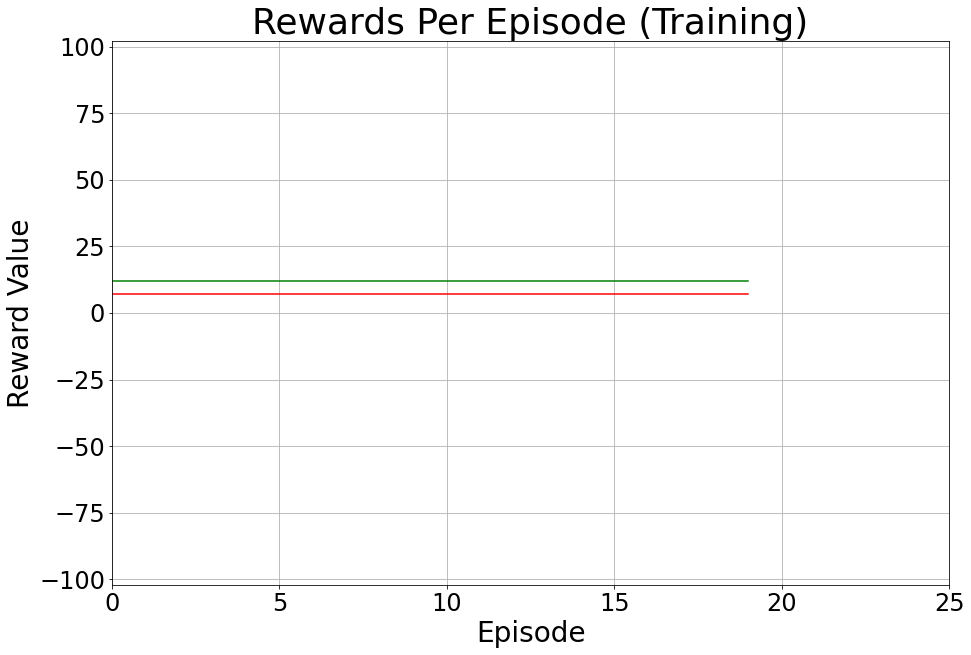

In [136]:
plt.clf()
plt.figure(figsize=(15, 10))
plt.plot(marioQD.reward_list, 'r-')
plt.plot(marioSD.reward_list, 'g-')
plt.xlabel('Episode', fontsize=28)
plt.ylabel('Reward Value', fontsize=28)
plt.title('Rewards Per Episode (Training)', fontsize=36)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
# plt.yticks([-100, -50, 0, 10, 20], fontsize=24)
plt.ylim(ymin=-102, ymax=102)
plt.xlim(xmin=0, xmax=1000)
plt.grid()
plt.show()

plt.clf()
plt.figure(figsize=(15, 10))
plt.plot(marioSD.reward_list_test, 'g-')
plt.plot(marioQD.reward_list_test, 'r-')
plt.xlabel('Episode', fontsize=28)
plt.ylabel('Reward Value', fontsize=28)
plt.title('Rewards Per Episode (Training)', fontsize=36)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
# plt.yticks([-100, -50, 0, 10, 20], fontsize=24)
plt.ylim(ymin=-102, ymax=102)
plt.xlim(xmin=0, xmax=25)
plt.grid()
plt.show()

In [21]:

envD = MyMarioEnvironment(environment=STATES,actions=ACTIONS,rewards=REWARDS,p_transition=1.0,environment_type='deterministic')
marioQD_g1 = QLearningMarioAgent(envD)
marioQD_g1.initialize_q_table("zeros")
marioQD_g1.train(episodes=5000, gamma=0.10, lmda=None, epsilon=1.0)

reward_g1 = marioQD_g1.reward_list

marioQD_g2 = QLearningMarioAgent(envD)
marioQD_g2.initialize_q_table("zeros")
marioQD_g2.train(episodes=5000, gamma=0.50, lmda=None, epsilon=1.0)

reward_g2 = marioQD_g2.reward_list

marioQD_g3 = QLearningMarioAgent(envD)
marioQD_g3.initialize_q_table("zeros")
marioQD_g3.train(episodes=5000, gamma=0.90, lmda=None, epsilon=1.0)

reward_g3 = marioQD_g3.reward_list



Episode - 1 : Done 	 Reward: -30.0 	 Timesteps: 100
Episode - 2 : Done 	 Reward: -6.0 	 Timesteps: 50
Episode - 3 : Done 	 Reward: 14.0 	 Timesteps: 44
Episode - 4 : Done 	 Reward: -22.0 	 Timesteps: 100
Episode - 5 : Done 	 Reward: -42.0 	 Timesteps: 100
Episode - 6 : Done 	 Reward: -72.0 	 Timesteps: 100
Episode - 7 : Done 	 Reward: -16.0 	 Timesteps: 55
Episode - 8 : Done 	 Reward: 5.0 	 Timesteps: 32
Episode - 9 : Done 	 Reward: -3.0 	 Timesteps: 53
Episode - 10 : Done 	 Reward: 9.0 	 Timesteps: 69
Episode - 11 : Done 	 Reward: -22.0 	 Timesteps: 100
Episode - 12 : Done 	 Reward: -4.0 	 Timesteps: 63
Episode - 13 : Done 	 Reward: -30.0 	 Timesteps: 100
Episode - 14 : Done 	 Reward: -29.0 	 Timesteps: 100
Episode - 15 : Done 	 Reward: 7.0 	 Timesteps: 8
Episode - 16 : Done 	 Reward: -20.0 	 Timesteps: 100
Episode - 17 : Done 	 Reward: 10.0 	 Timesteps: 21
Episode - 18 : Done 	 Reward: 4.0 	 Timesteps: 25
Episode - 19 : Done 	 Reward: -26.0 	 Timesteps: 100
Episode - 20 : Done 	 Rewa

<Figure size 432x288 with 0 Axes>

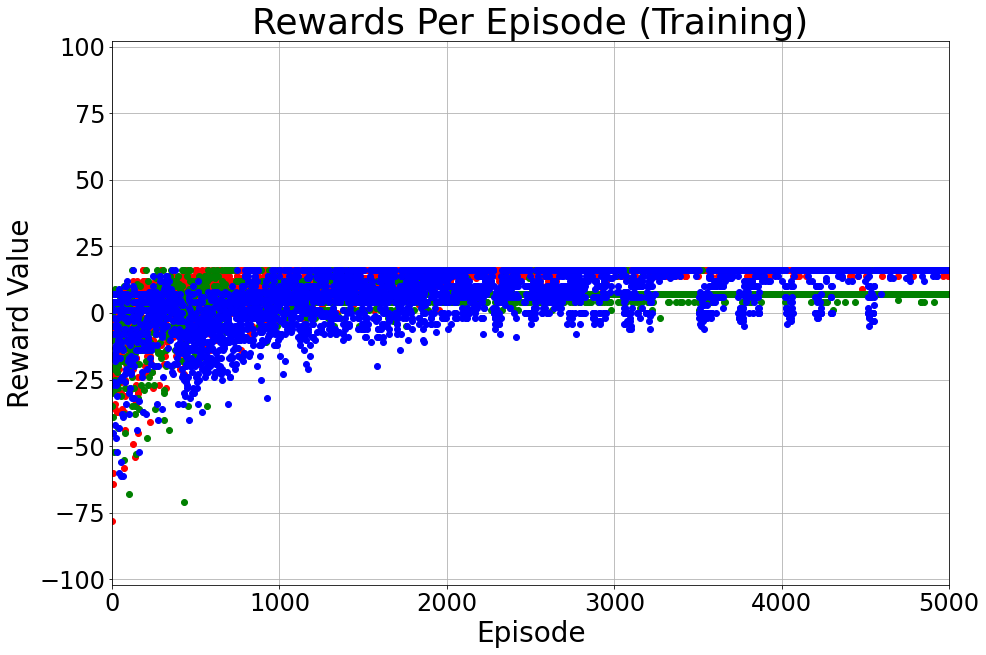

In [9]:
plt.clf()
plt.figure(figsize=(15, 10))
plt.plot(reward_g1, 'ro')
plt.plot(reward_g2, 'go')
plt.plot(reward_g3, 'bo')
plt.xlabel('Episode', fontsize=28)
plt.ylabel('Reward Value', fontsize=28)
plt.title('Rewards Per Episode (Training)', fontsize=36)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
# plt.yticks([-100, -50, 0, 10, 20], fontsize=24)
plt.ylim(ymin=-102, ymax=102)
plt.xlim(xmin=0, xmax=5000)
plt.grid()
plt.show()


In [27]:
nl = []
nm = []
no = []
for s in np.split(np.array(reward_g1), 500):
    nl.append((sum(s)/len(s)))

for s in np.split(np.array(reward_g2), 500):
    nm.append((sum(s)/len(s)))

for s in np.split(np.array(reward_g3), 500):
    no.append((sum(s)/len(s)))

<Figure size 432x288 with 0 Axes>

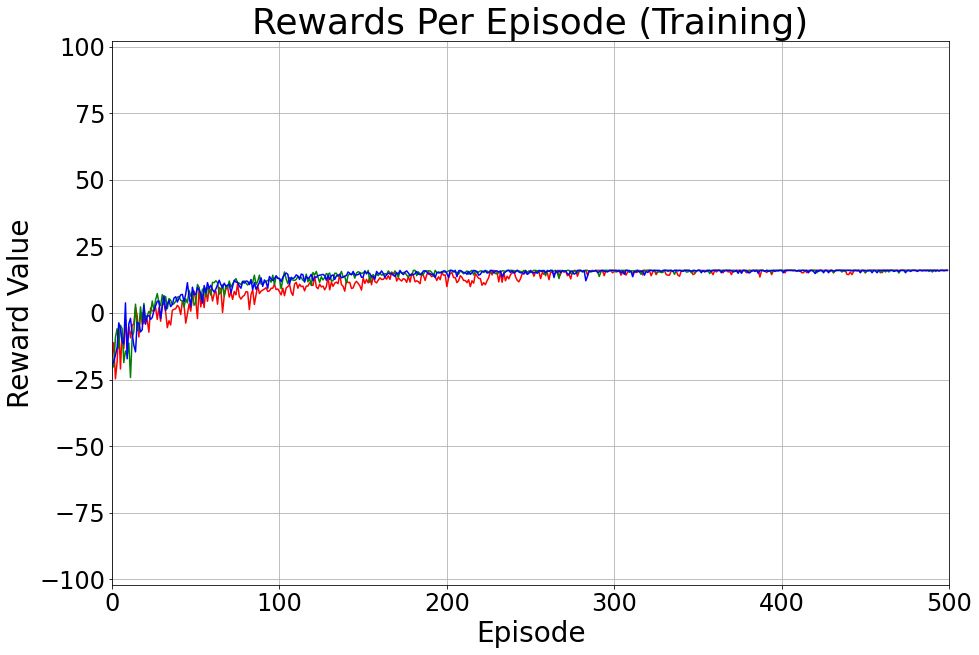

In [28]:
plt.clf()
plt.figure(figsize=(15, 10))
plt.plot(nl, 'r-')
plt.plot(nm, 'g-')
plt.plot(no, 'b-')
plt.xlabel('Episode', fontsize=28)
plt.ylabel('Reward Value', fontsize=28)
plt.title('Rewards Per Episode (Training)', fontsize=36)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.ylim(ymin=-102, ymax=102)
plt.xlim(xmin=0, xmax=500)
plt.grid()
plt.show()

In [29]:
envD = MyMarioEnvironment(environment=STATES,actions=ACTIONS,rewards=REWARDS,p_transition=1.0,environment_type='deterministic')
marioQD_ts1 = QLearningMarioAgent(envD)
marioQD_ts1.initialize_q_table("zeros")
marioQD_ts1.train(episodes=5000, steps=20,lmda=None, epsilon=1.0)

reward_g1 = marioQD_ts1.reward_list

marioQD_ts2 = QLearningMarioAgent(envD)
marioQD_ts2.initialize_q_table("zeros")
marioQD_ts2.train(episodes=5000, steps=50,lmda=None, epsilon=1.0)

reward_g2 = marioQD_ts2.reward_list

marioQD_ts3 = QLearningMarioAgent(envD)
marioQD_ts3.initialize_q_table("zeros")
marioQD_ts3.train(episodes=5000, steps=100,lmda=None, epsilon=1.0)

reward_g3 = marioQD_ts3.reward_list

Episode - 1 : Done 	 Reward: 5.0 	 Timesteps: 16
Episode - 2 : Done 	 Reward: -9.0 	 Timesteps: 20
Episode - 3 : Done 	 Reward: 7.0 	 Timesteps: 10
Episode - 4 : Done 	 Reward: 7.0 	 Timesteps: 16
Episode - 5 : Done 	 Reward: -19.0 	 Timesteps: 20
Episode - 6 : Done 	 Reward: -3.0 	 Timesteps: 20
Episode - 7 : Done 	 Reward: -4.0 	 Timesteps: 20
Episode - 8 : Done 	 Reward: -17.0 	 Timesteps: 20
Episode - 9 : Done 	 Reward: 7.0 	 Timesteps: 9
Episode - 10 : Done 	 Reward: -21.0 	 Timesteps: 20
Episode - 11 : Done 	 Reward: -6.0 	 Timesteps: 20
Episode - 12 : Done 	 Reward: 4.0 	 Timesteps: 20
Episode - 13 : Done 	 Reward: -17.0 	 Timesteps: 20
Episode - 14 : Done 	 Reward: 0.0 	 Timesteps: 20
Episode - 15 : Done 	 Reward: -10.0 	 Timesteps: 20
Episode - 16 : Done 	 Reward: 1.0 	 Timesteps: 18
Episode - 17 : Done 	 Reward: 0.0 	 Timesteps: 20
Episode - 18 : Done 	 Reward: 0.0 	 Timesteps: 20
Episode - 19 : Done 	 Reward: 4.0 	 Timesteps: 19
Episode - 20 : Done 	 Reward: -6.0 	 Timesteps

<Figure size 432x288 with 0 Axes>

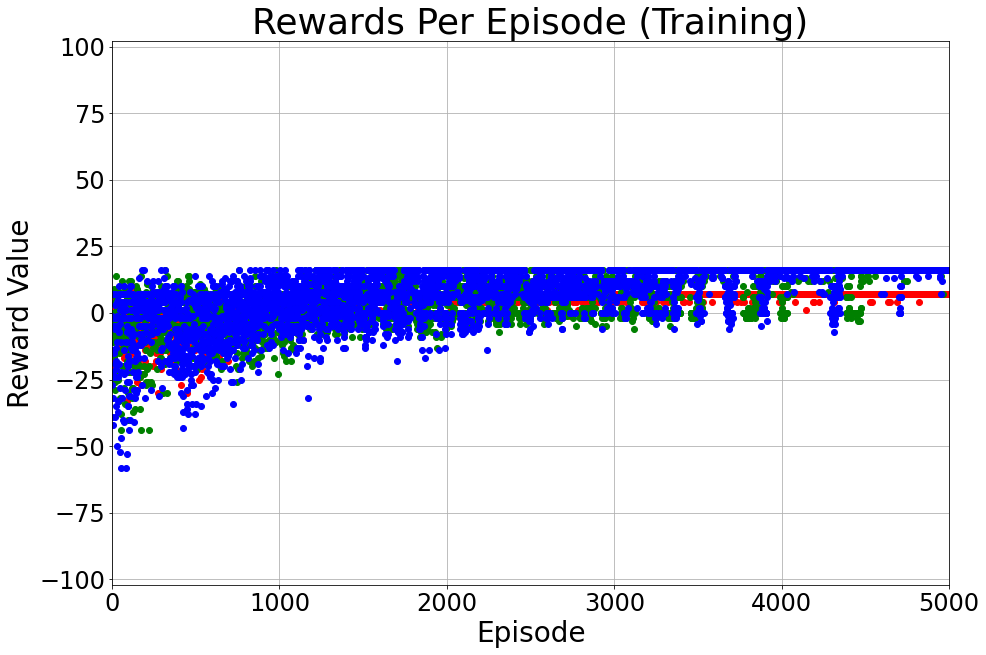

In [30]:
plt.clf()
plt.figure(figsize=(15, 10))
plt.plot(reward_g1, 'ro')
plt.plot(reward_g2, 'go')
plt.plot(reward_g3, 'bo')
plt.xlabel('Episode', fontsize=28)
plt.ylabel('Reward Value', fontsize=28)
plt.title('Rewards Per Episode (Training)', fontsize=36)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
# plt.yticks([-100, -50, 0, 10, 20], fontsize=24)
plt.ylim(ymin=-102, ymax=102)
plt.xlim(xmin=0, xmax=5000)
plt.grid()
plt.show()

In [37]:
nl = []
nm = []
no = []
for s in np.split(np.array(reward_g1), 50):
    nl.append((sum(s)/len(s)))

for s in np.split(np.array(reward_g2), 50):
    nm.append((sum(s)/len(s)))

for s in np.split(np.array(reward_g3), 50):
    no.append((sum(s)/len(s)))

<Figure size 432x288 with 0 Axes>

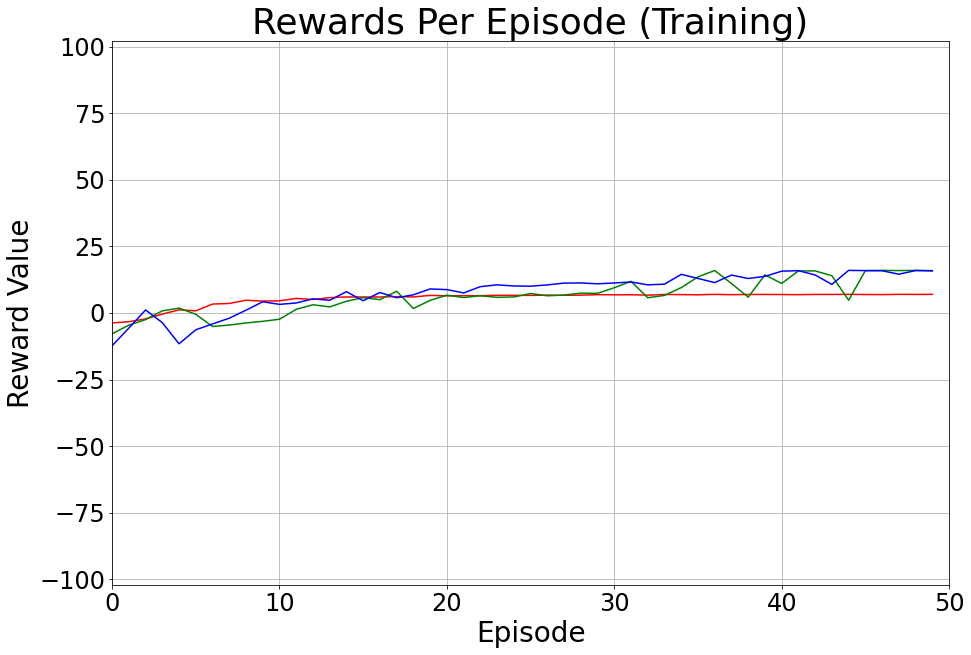

In [38]:
plt.clf()
plt.figure(figsize=(15, 10))
plt.plot(nl, 'r-')
plt.plot(nm, 'g-')
plt.plot(no, 'b-')
plt.xlabel('Episode', fontsize=28)
plt.ylabel('Reward Value', fontsize=28)
plt.title('Rewards Per Episode (Training)', fontsize=36)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.ylim(ymin=-102, ymax=102)
plt.xlim(xmin=0, xmax=50)
plt.grid()
plt.show()